### Threshold-Based Detector

To differentiate normal behavior from attack activity, the current signal is
resampled to one-second intervals and smoothed. Using only benign
segments, we compute the mean and standard deviation of the current and
define a statistical threshold:

$$
\text{threshold} = \mu_{\text{normal}} + 2\sigma_{\text{normal}}
$$

Any second in which the smoothed current exceeds this limit is flagged as
anomalous. This rule is applied uniformly across all attack types
(bruteforce, CTF, portscan, DoS), producing the binary decisions (TP, FP,
TN, FN) used in the later evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/pi/pi_bruteforce_large
Exists? True
CSV files found: 16

Processing: pi_hydra_t16_cke.csv



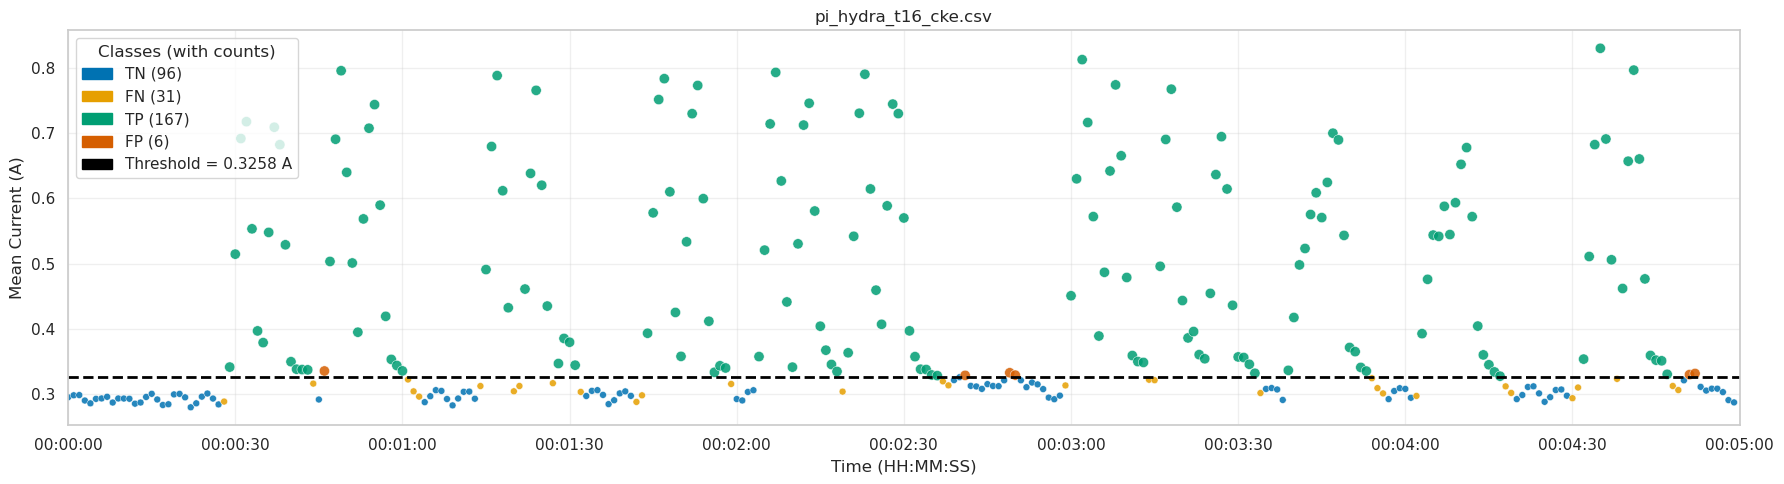


Processing: pi_hydra_t16_ike.csv



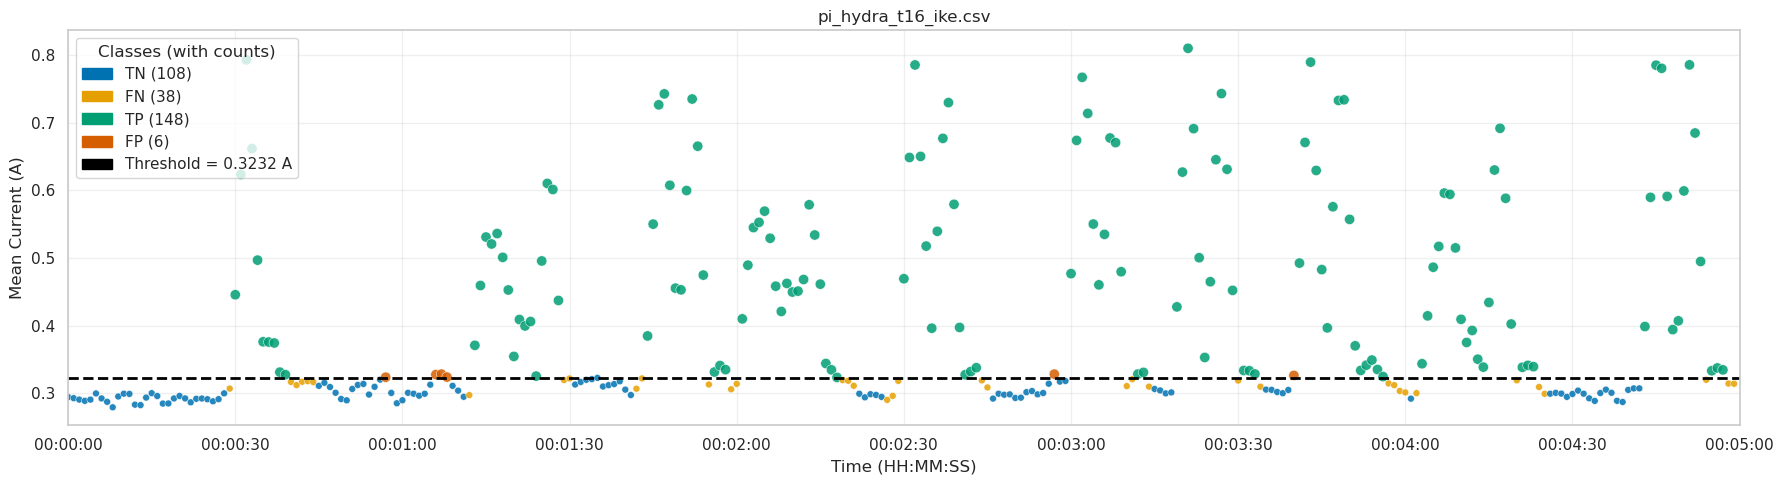


Processing: pi_hydra_t1_cke.csv



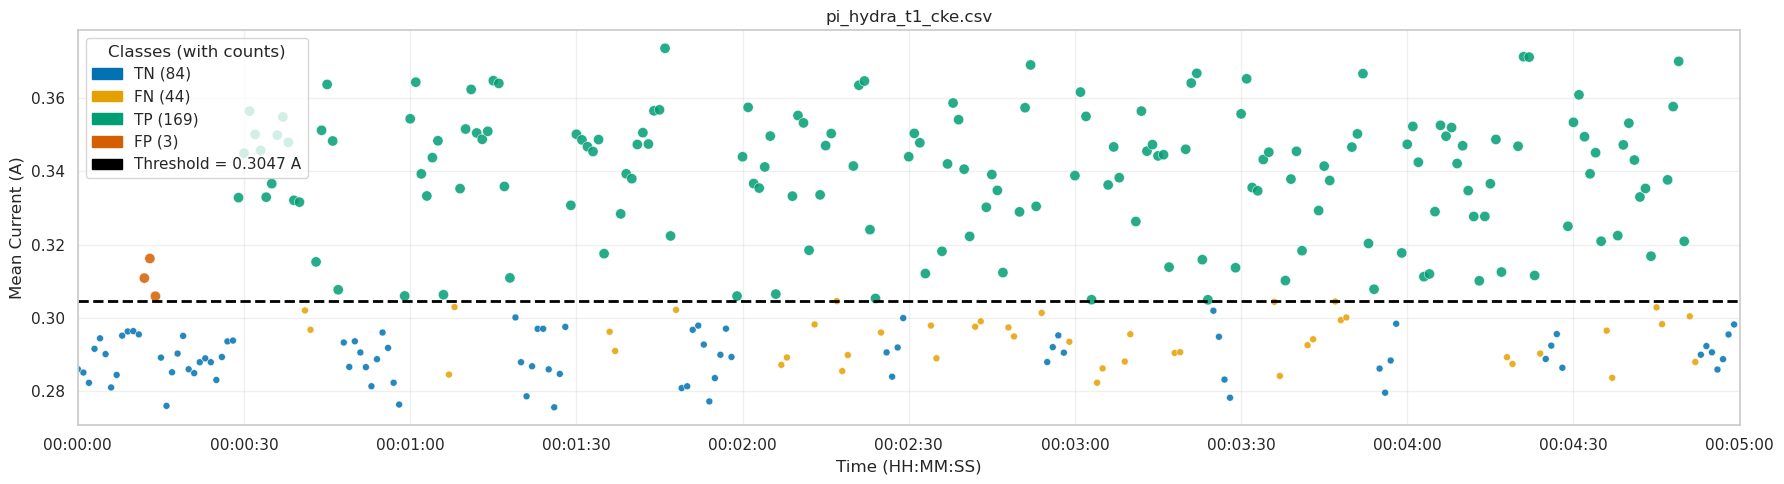


Processing: pi_hydra_t1_ike.csv



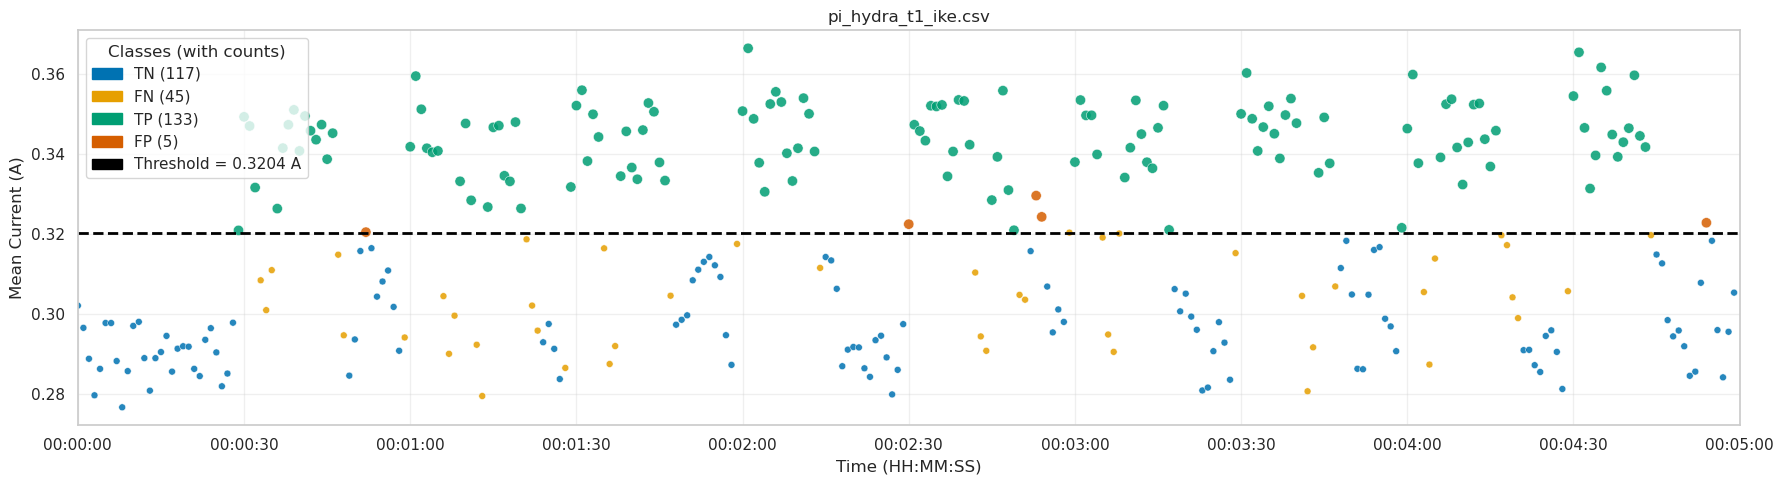


Processing: pi_hydra_t32_cke.csv



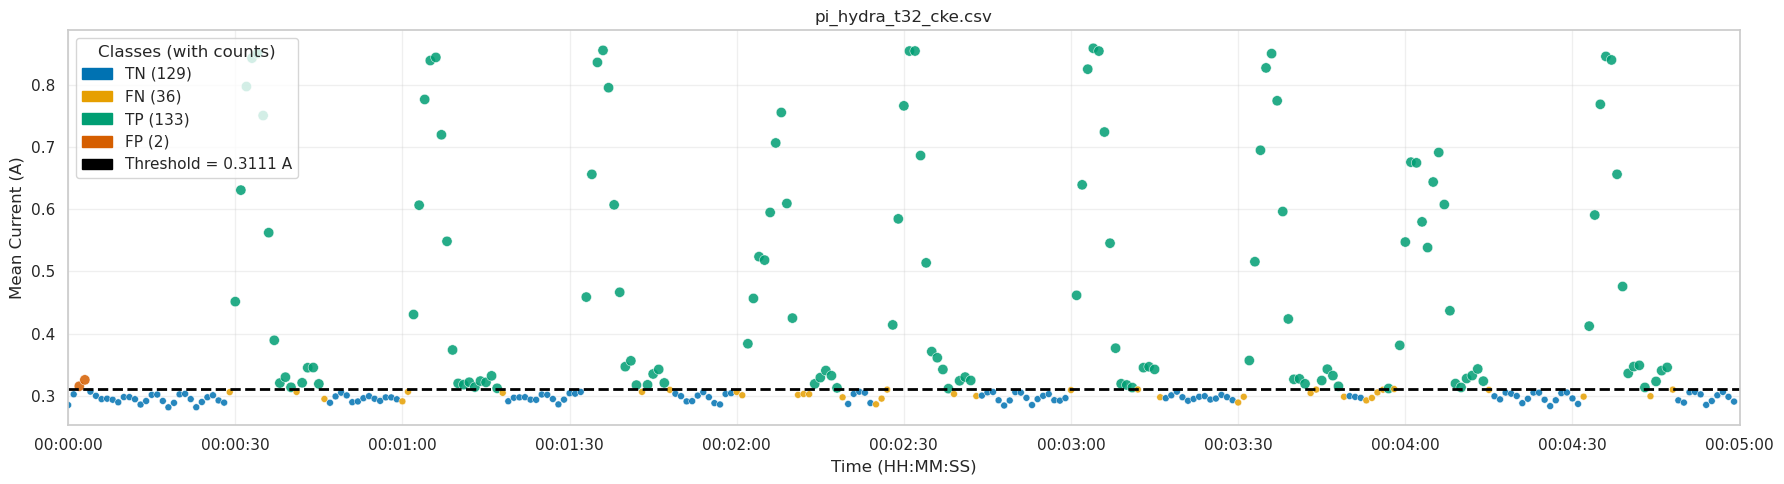


Processing: pi_hydra_t32_ike.csv



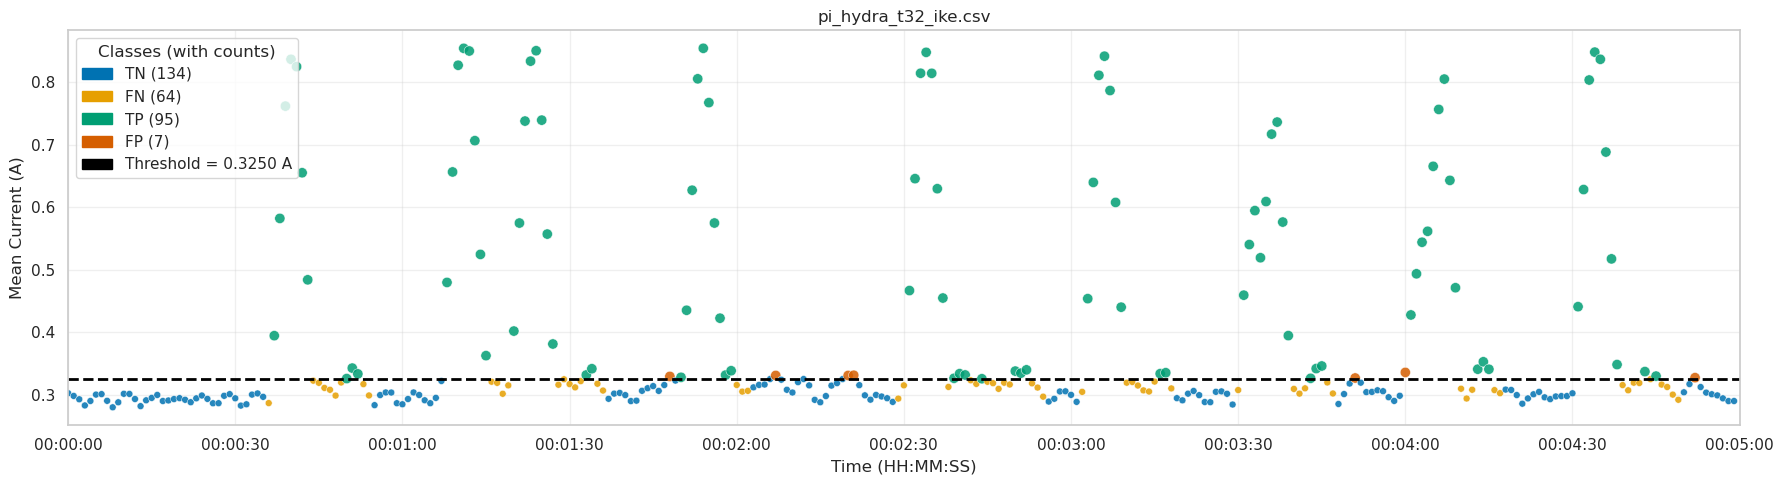


Processing: pi_hydra_t4_cke.csv



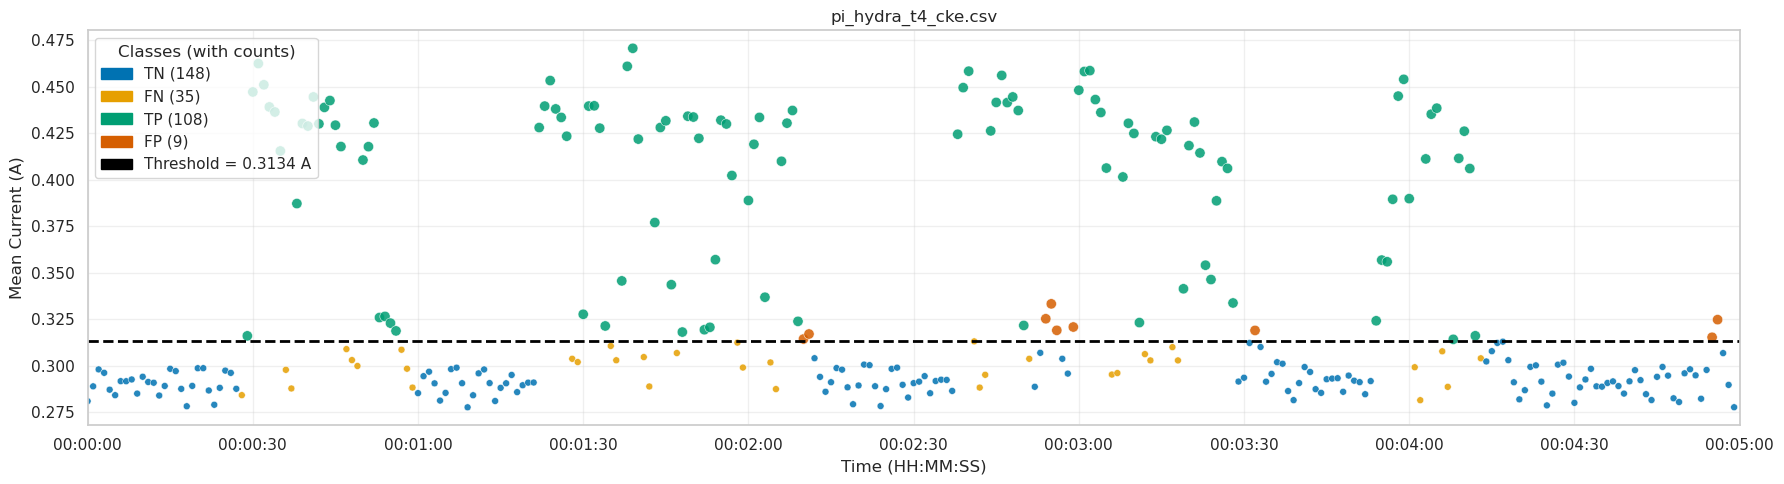


Processing: pi_hydra_t4_ike.csv



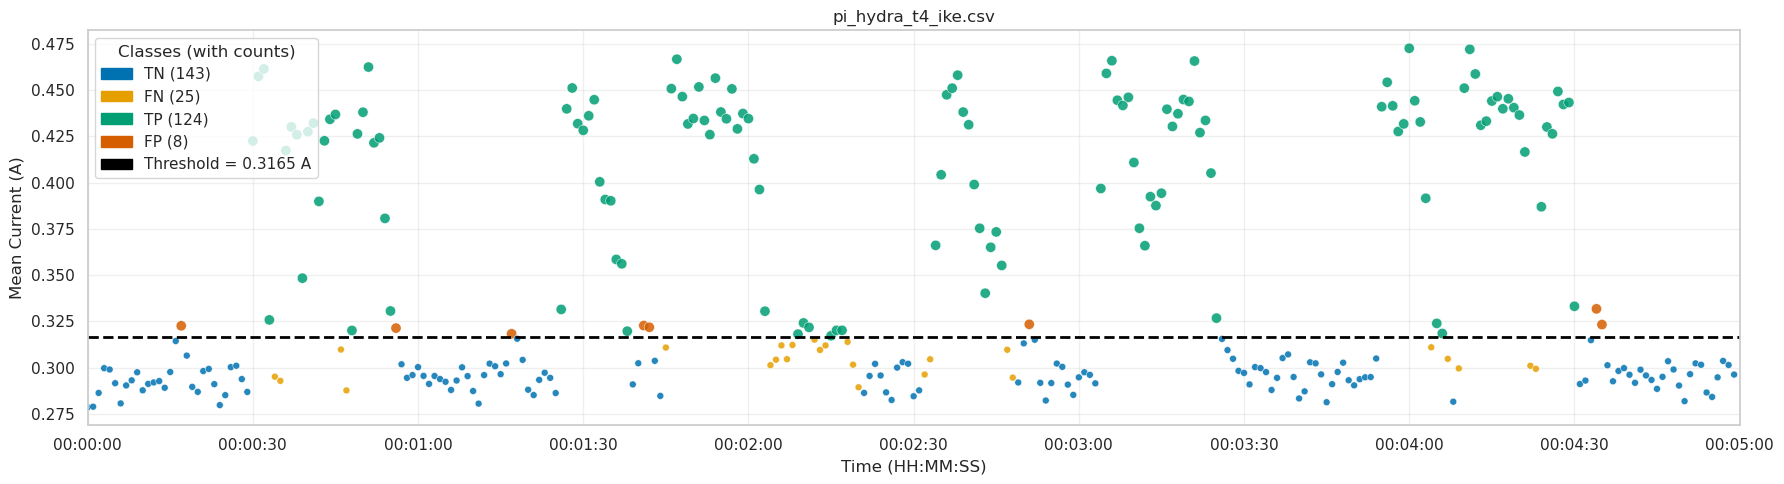


Saved: results_threshold/pi/pi_bruteforce_large/summary.csv


filename                   folder   TP  FP   TN  FN
0  pi_hydra_t16_cke.csv  /pi/pi_bruteforce_large  167   6   96  31
1  pi_hydra_t16_ike.csv  /pi/pi_bruteforce_large  148   6  108  38
2   pi_hydra_t1_cke.csv  /pi/pi_bruteforce_large  169   3   84  44
3   pi_hydra_t1_ike.csv  /pi/pi_bruteforce_large  133   5  117  45
4  pi_hydra_t32_cke.csv  /pi/pi_bruteforce_large  133   2  129  36
5  pi_hydra_t32_ike.csv  /pi/pi_bruteforce_large   95   7  134  64
6   pi_hydra_t4_cke.csv  /pi/pi_bruteforce_large  108   9  148  35
7   pi_hydra_t4_ike.csv  /pi/pi_bruteforce_large  124   8  143  25

In [4]:
sns.set(style="whitegrid")

PI_BRUTEFORCE_PATH = Path("../../dragon_pi/pi/pi_bruteforce_large")

print("Absolute path:", PI_BRUTEFORCE_PATH.resolve())
print("Exists?", PI_BRUTEFORCE_PATH.exists())
print("CSV files found:", len(list(PI_BRUTEFORCE_PATH.glob('*.csv'))))
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(PI_BRUTEFORCE_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(PI_BRUTEFORCE_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / PI_BRUTEFORCE_PATH.parent.name / PI_BRUTEFORCE_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df


Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/dragon/dragon_bruteforce_large
Exists? True
CSV files found: 66

Processing: dragon_hydra_t16_0.csv



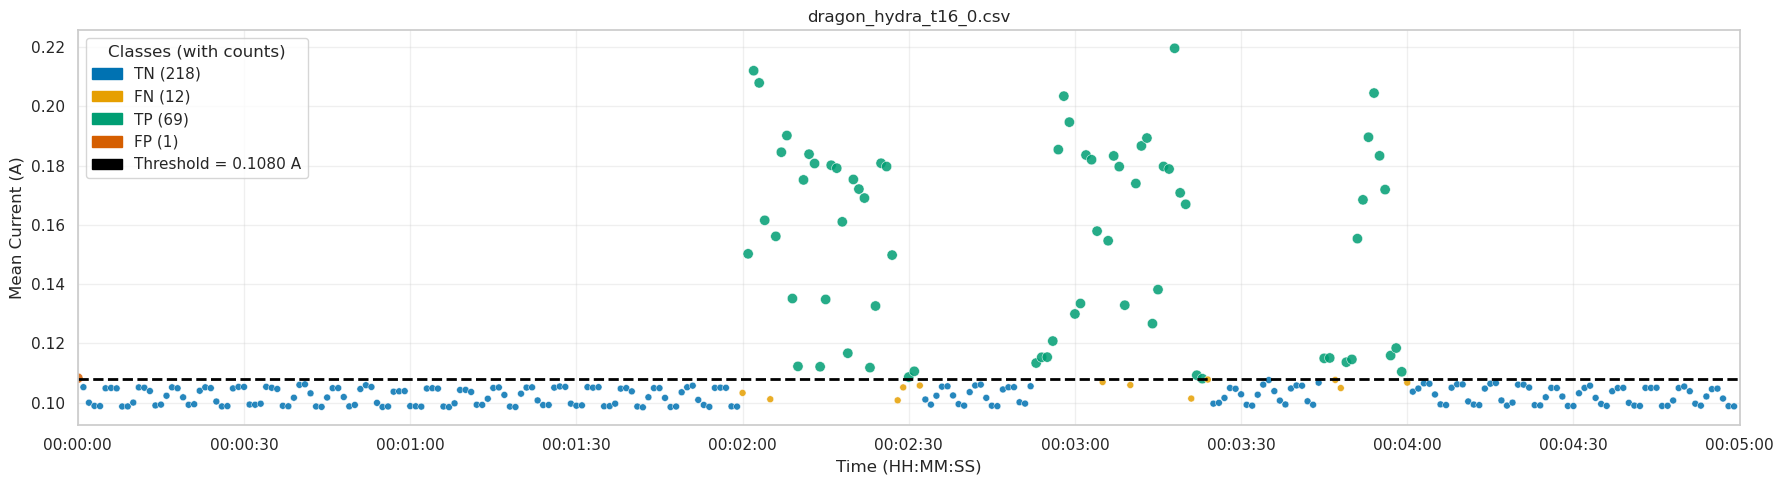


Processing: dragon_hydra_t16_1_cke.csv



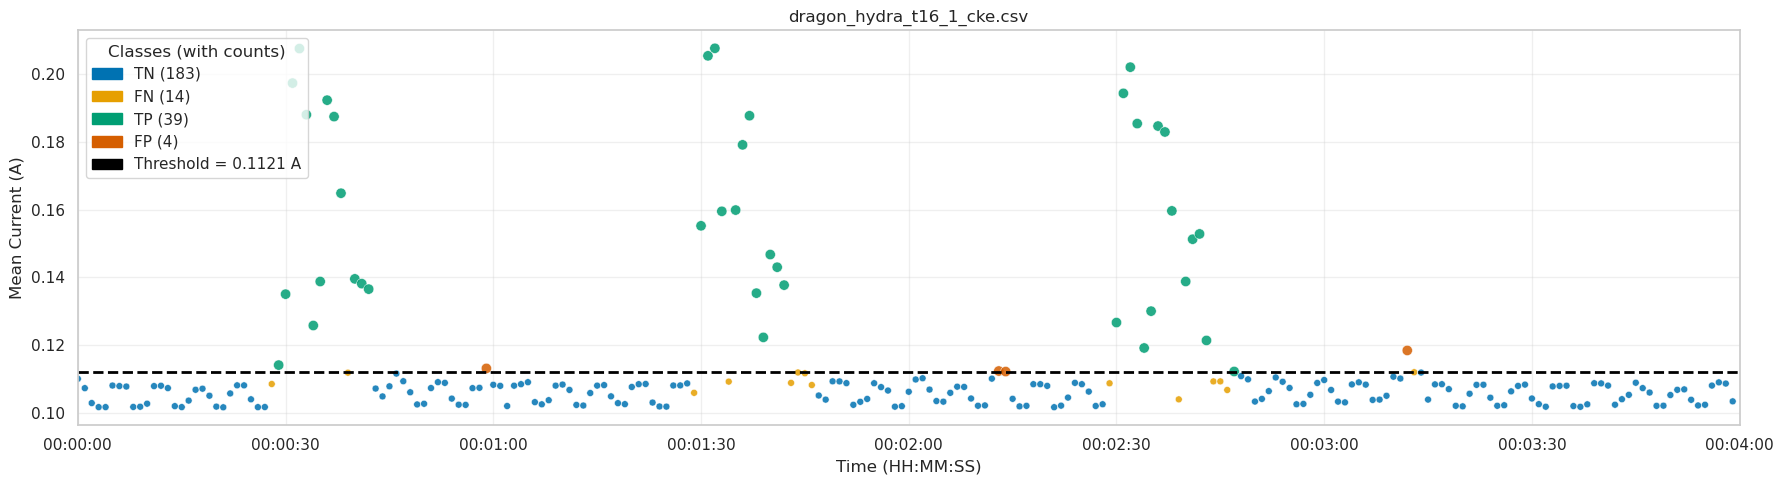


Processing: dragon_hydra_t16_1_ike.csv



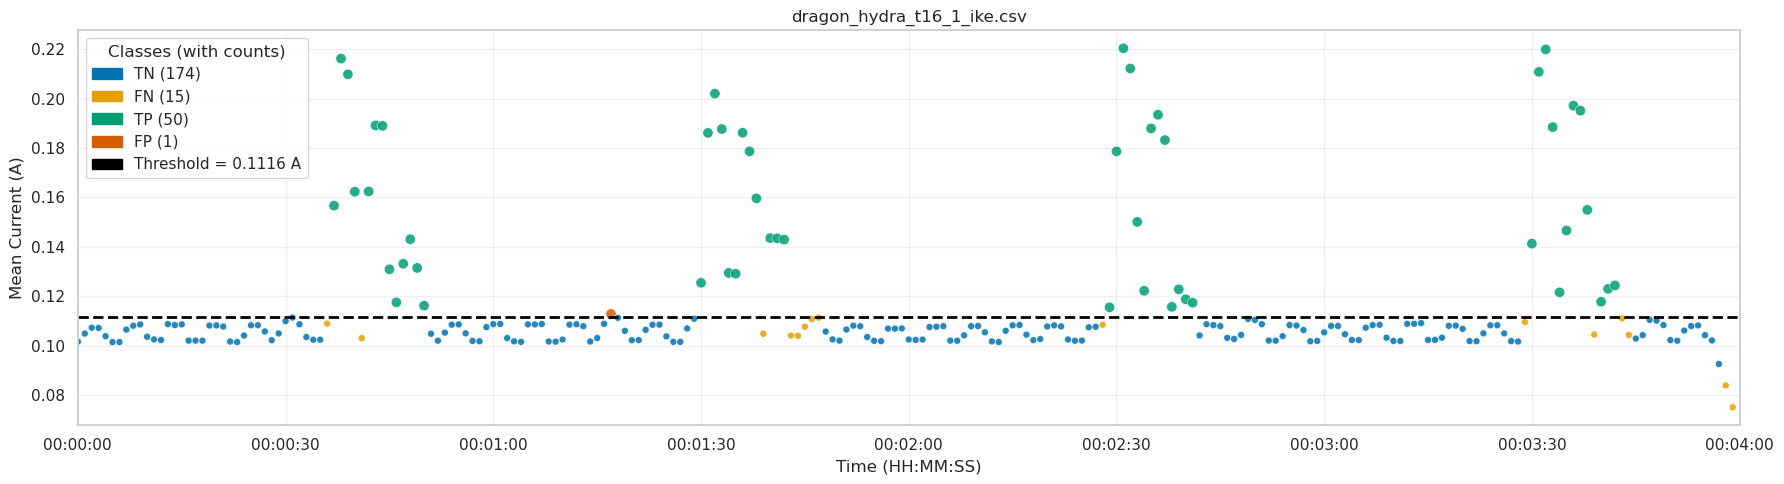


Processing: dragon_hydra_t16_2_cke.csv



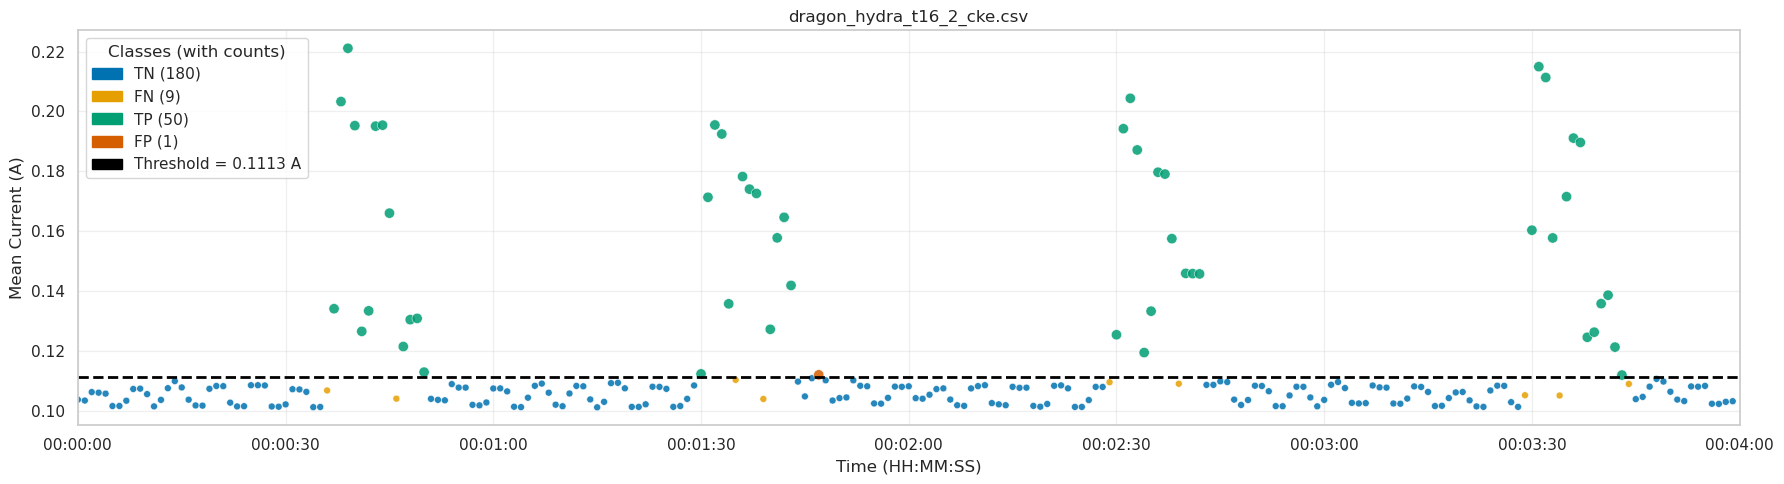


Processing: dragon_hydra_t16_2_ike.csv



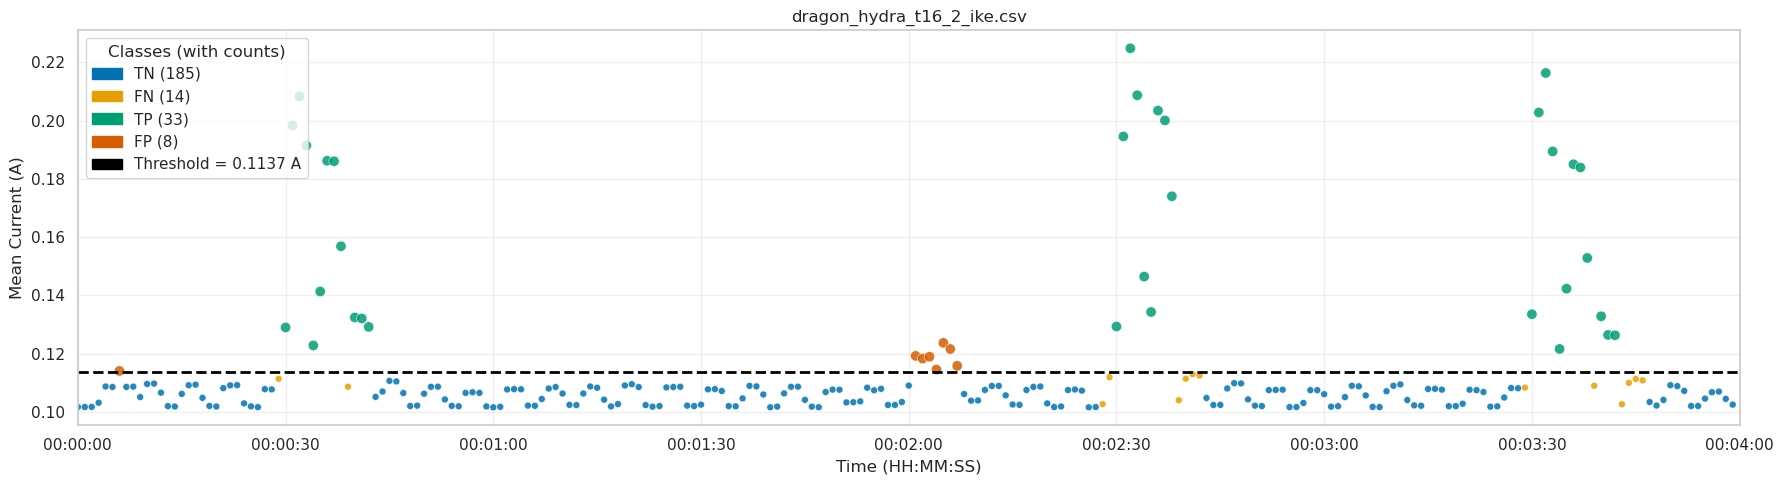


Processing: dragon_hydra_t16_3_cke.csv



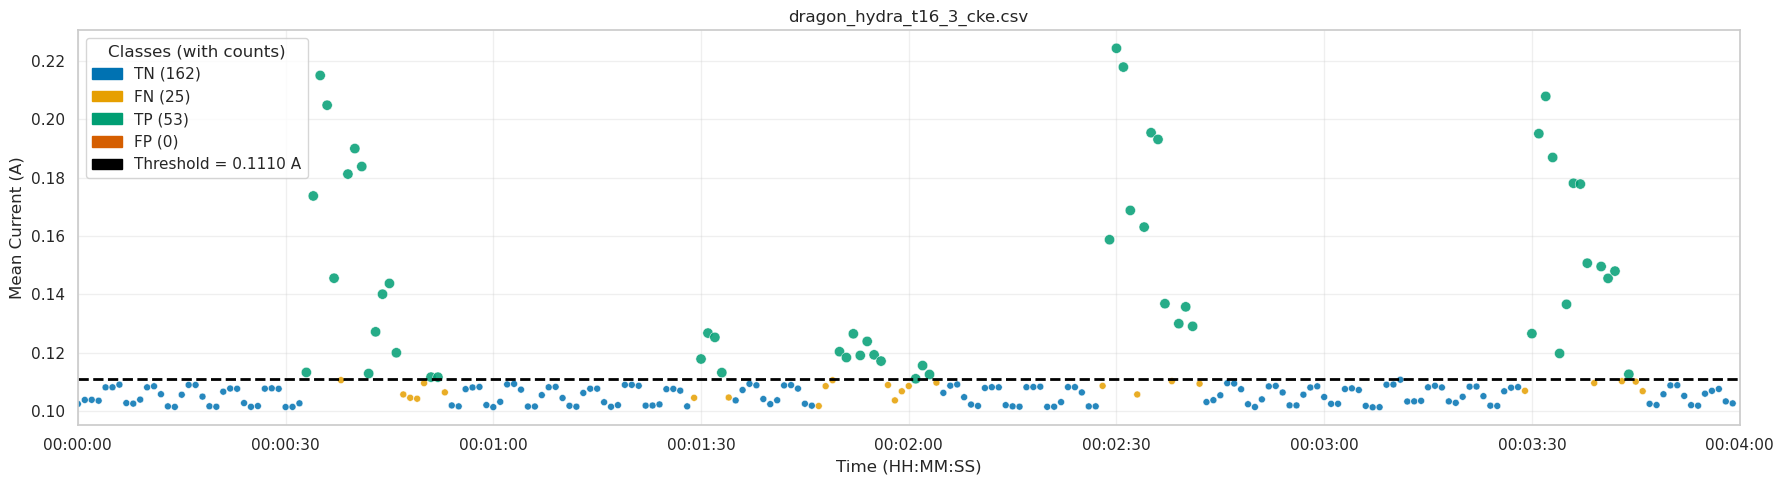


Processing: dragon_hydra_t16_3_ike.csv



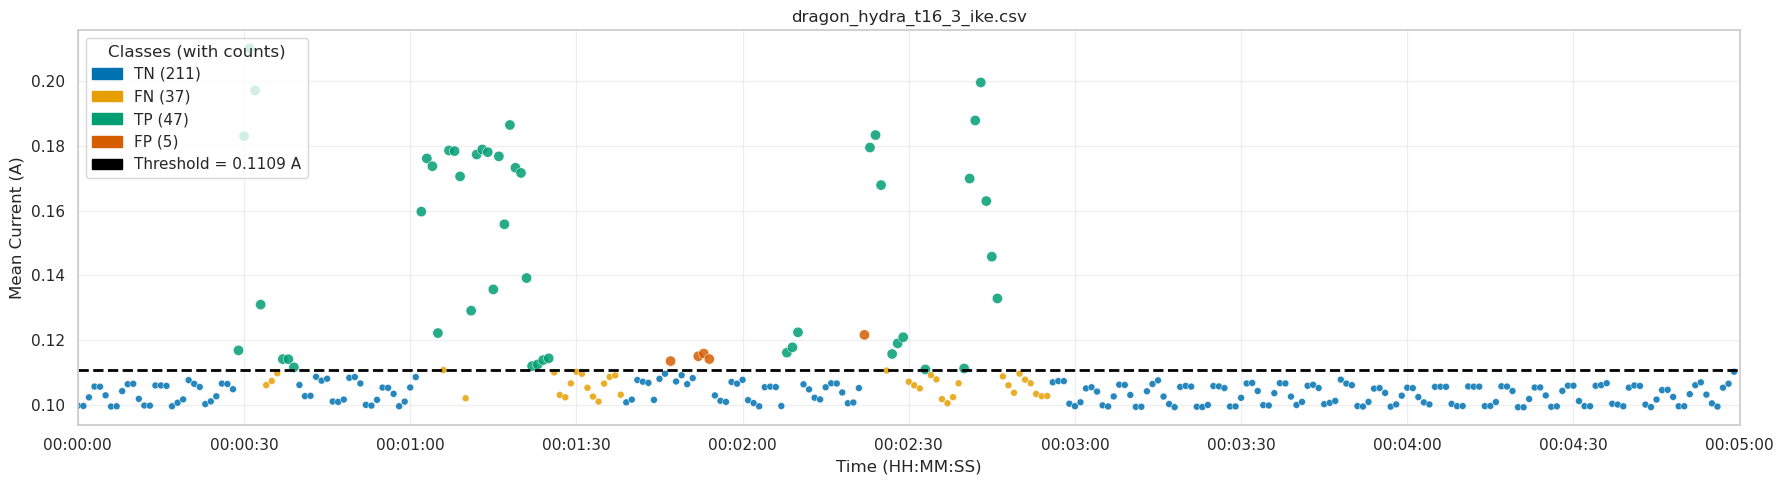


Processing: dragon_hydra_t16_4_cke.csv



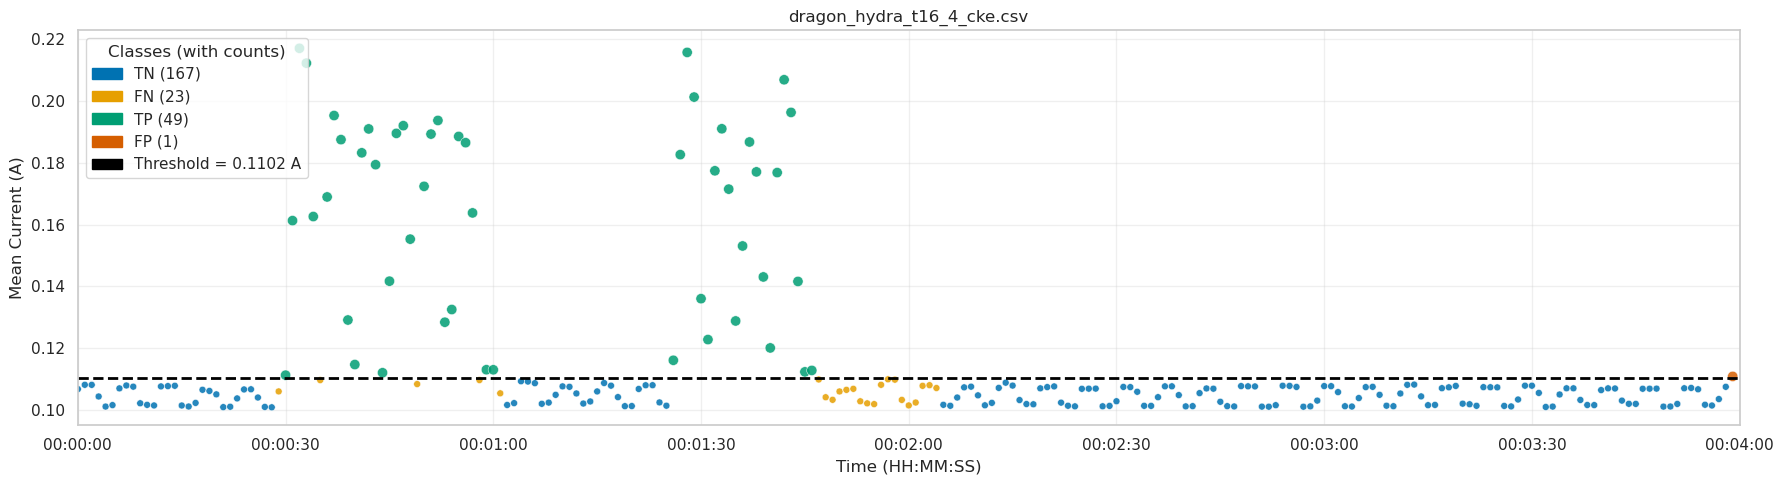


Processing: dragon_hydra_t16_4_ike.csv



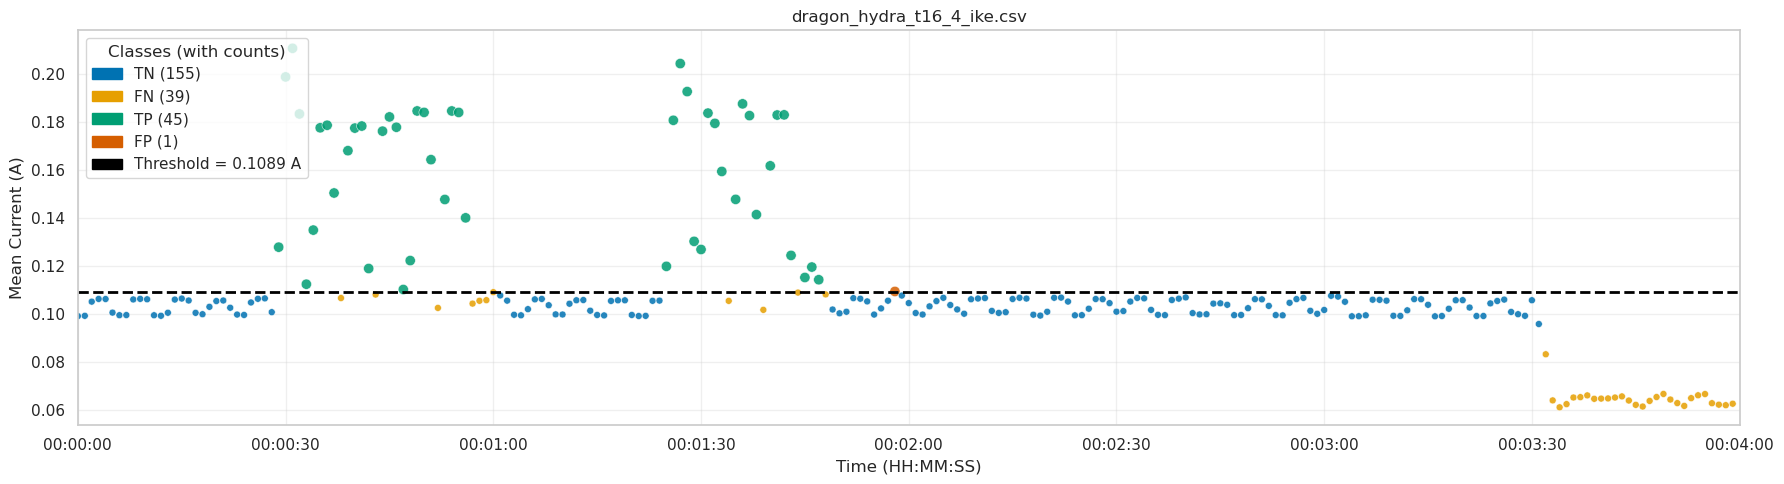


Processing: dragon_hydra_t16_5_cke.csv



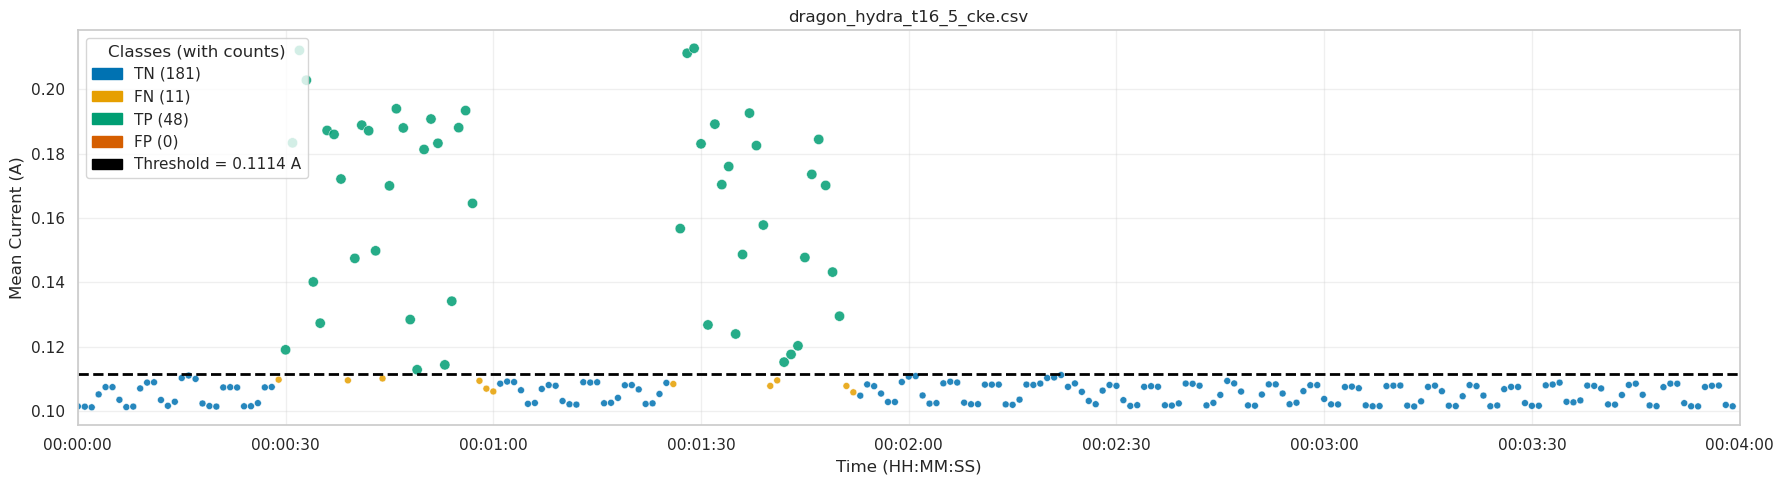


Processing: dragon_hydra_t16_5_ike.csv



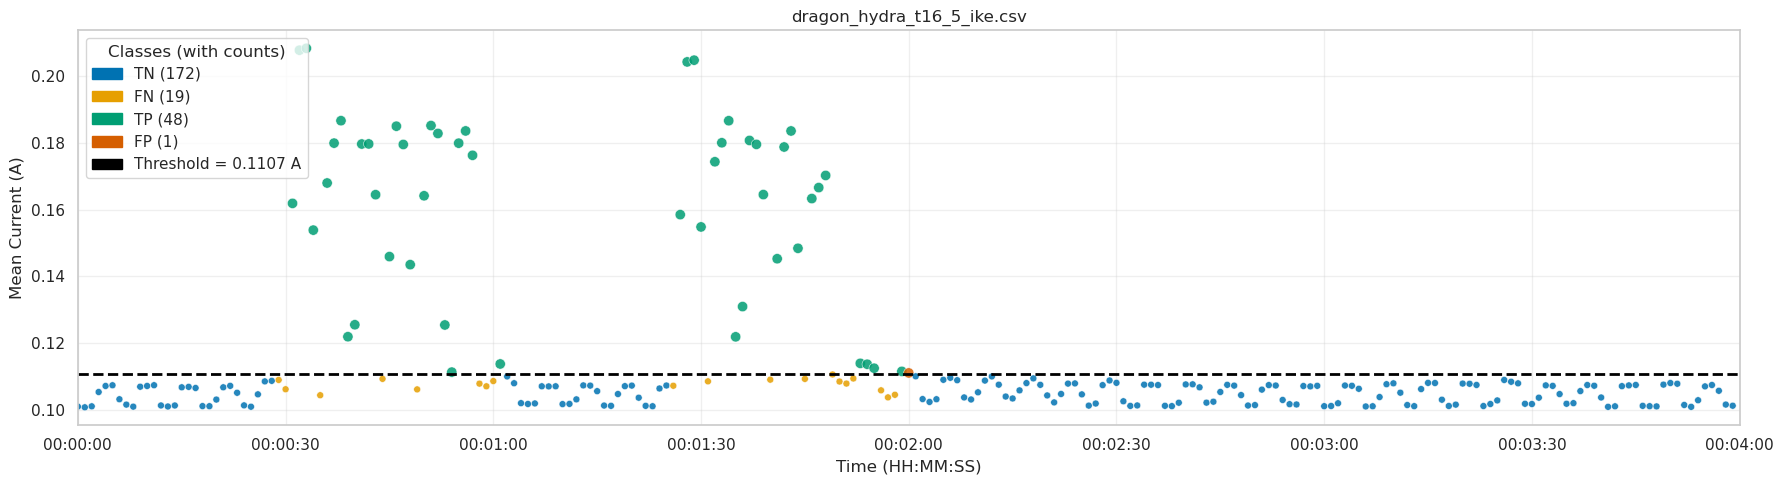


Processing: dragon_hydra_t16_6_cke.csv



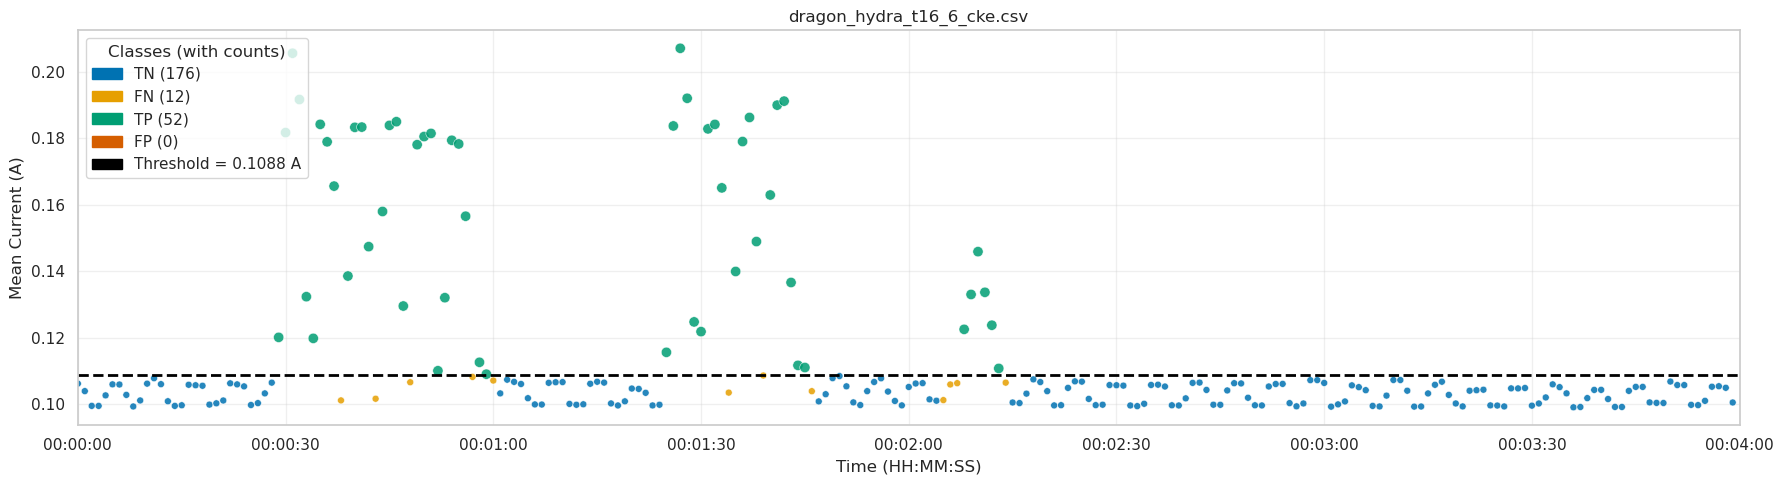


Processing: dragon_hydra_t16_6_ike.csv



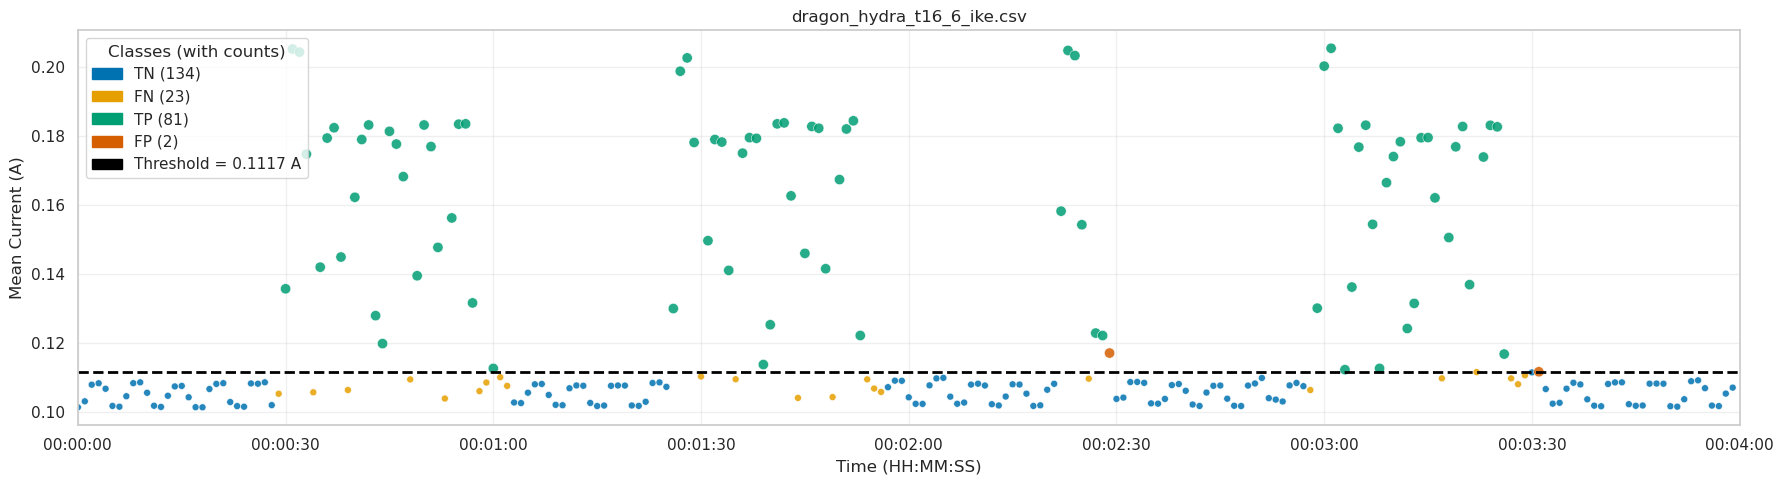


Processing: dragon_hydra_t16_7_cke.csv



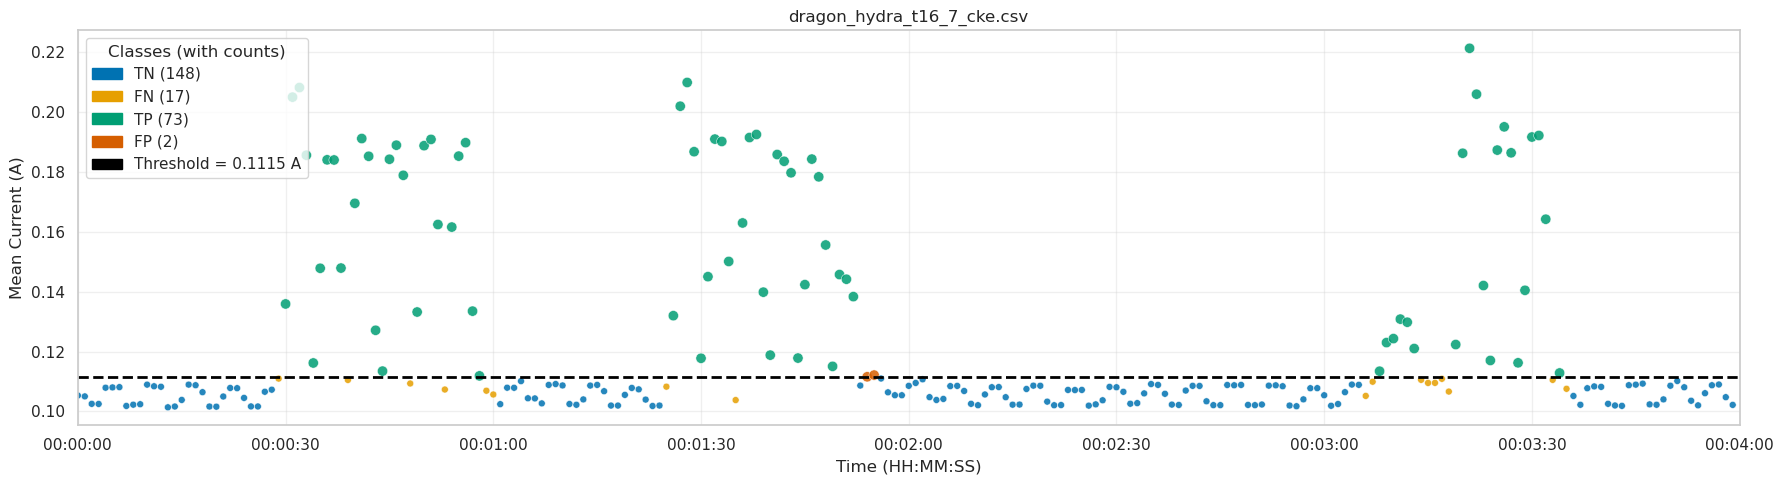


Processing: dragon_hydra_t16_7_ike.csv



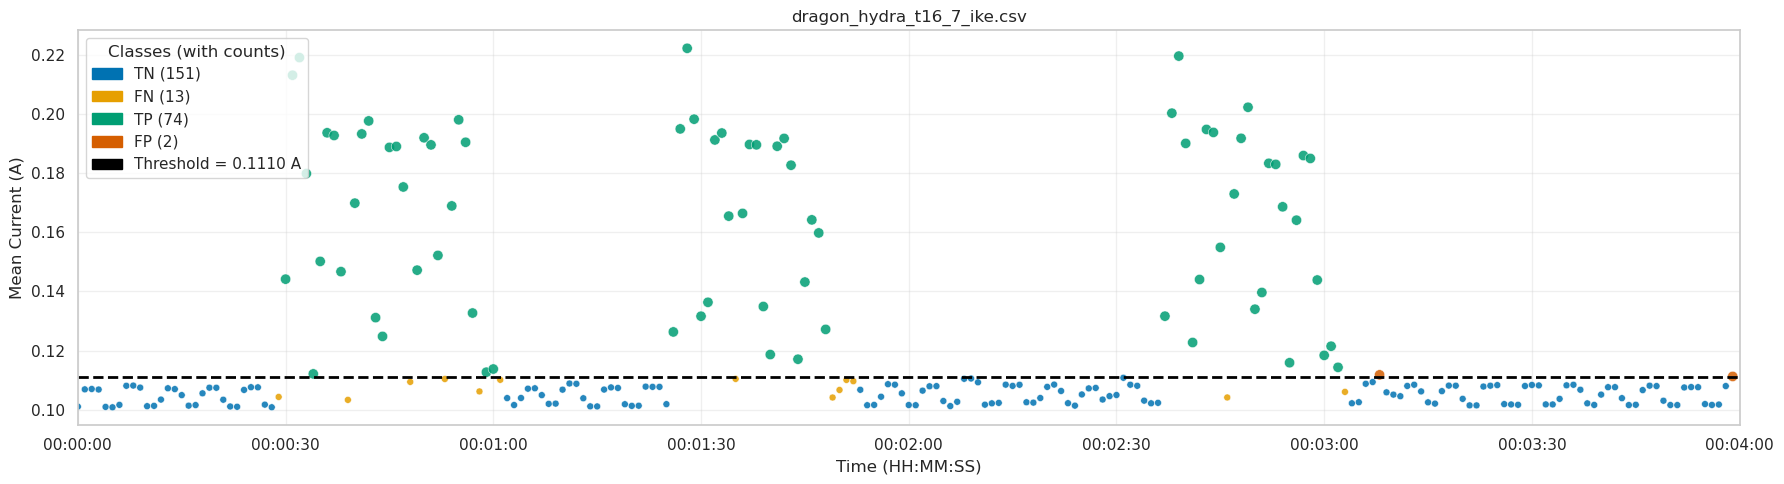


Processing: dragon_hydra_t16_8_cke.csv



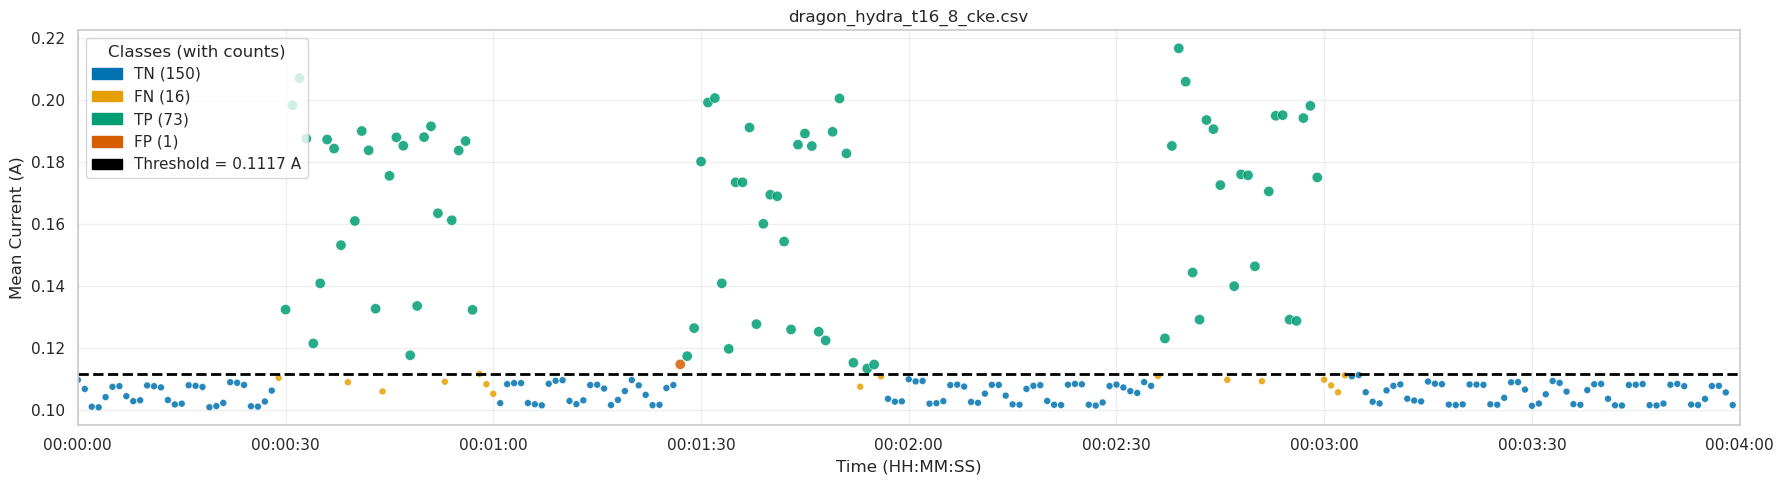


Processing: dragon_hydra_t1_1_cke.csv



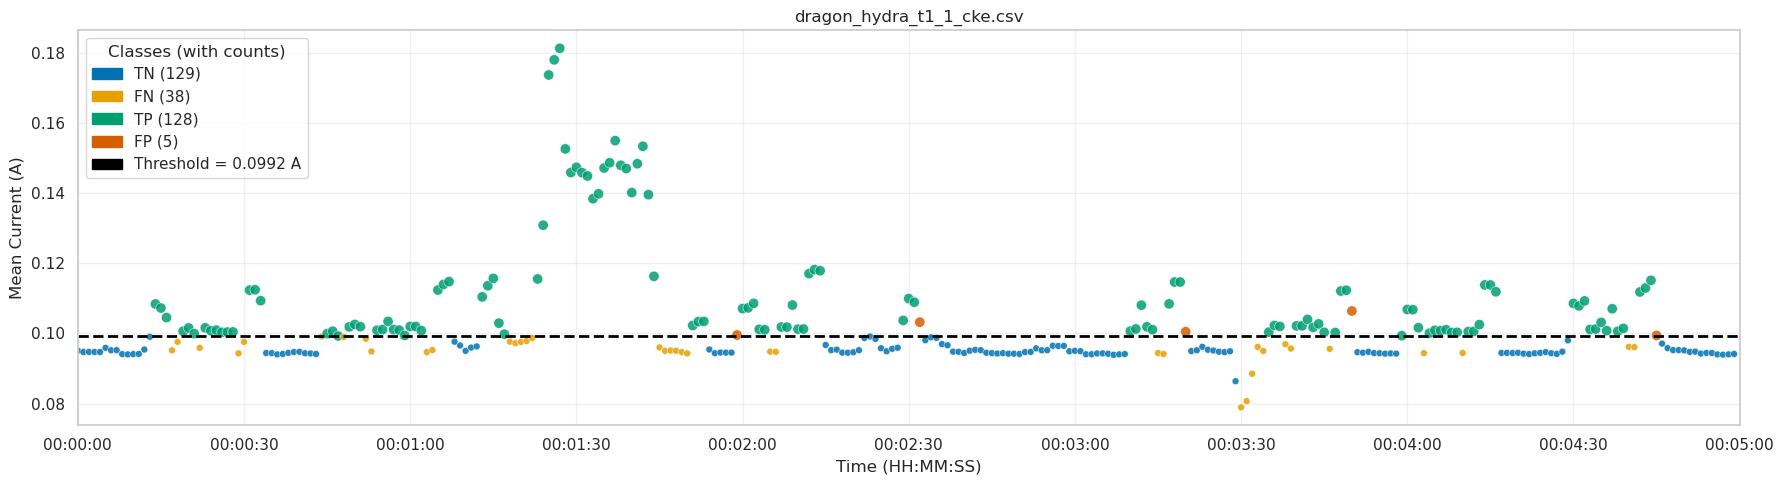


Processing: dragon_hydra_t1_1_ike.csv



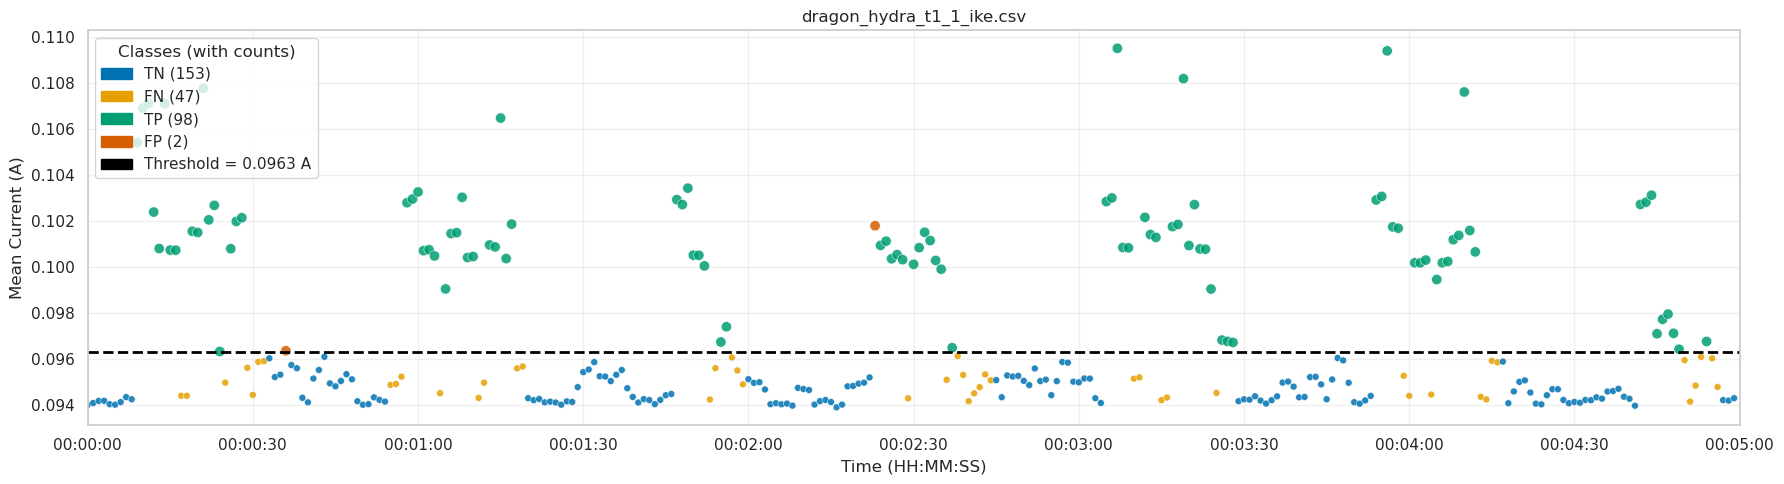


Processing: dragon_hydra_t1_2_cke.csv



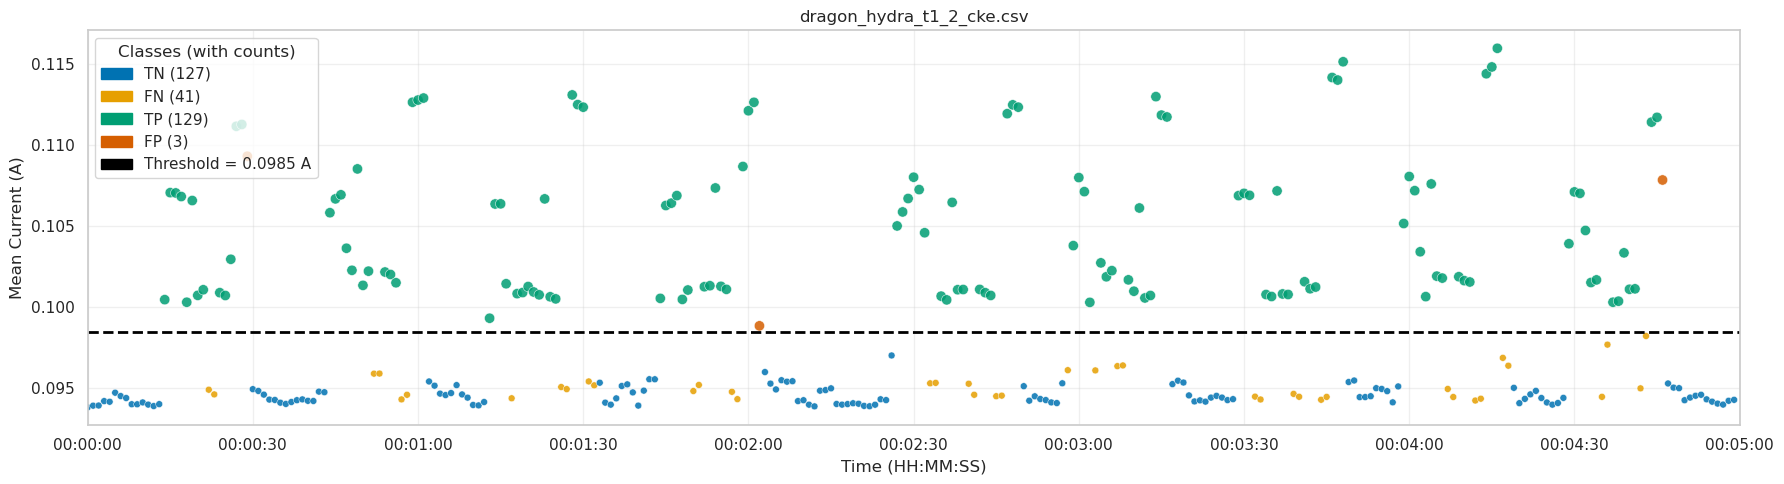


Processing: dragon_hydra_t1_2_ike.csv



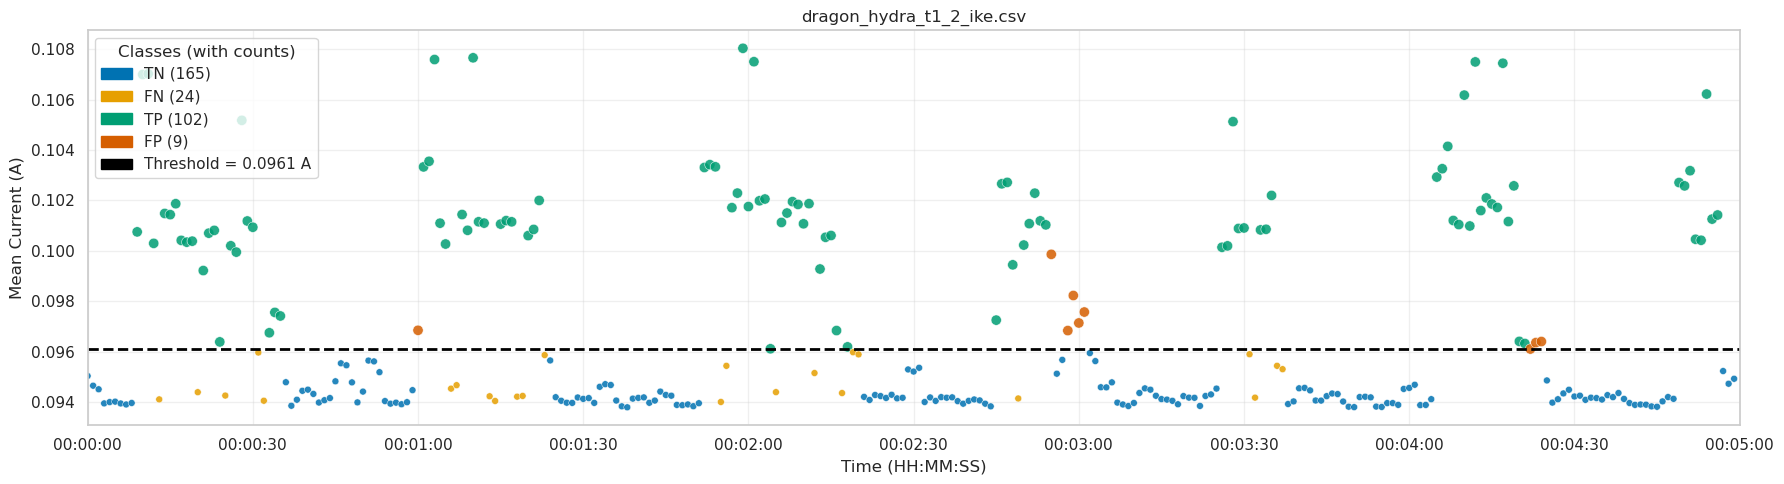


Processing: dragon_hydra_t1_3_ike.csv



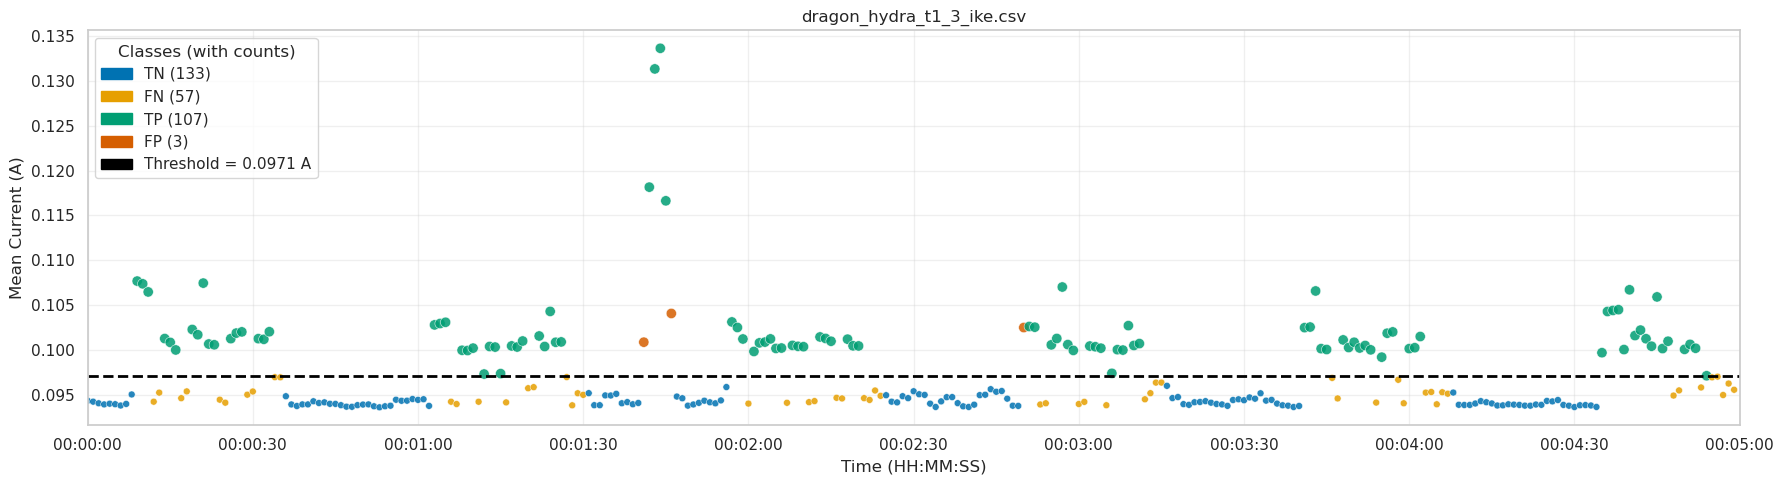


Processing: dragon_hydra_t32_1_cke.csv



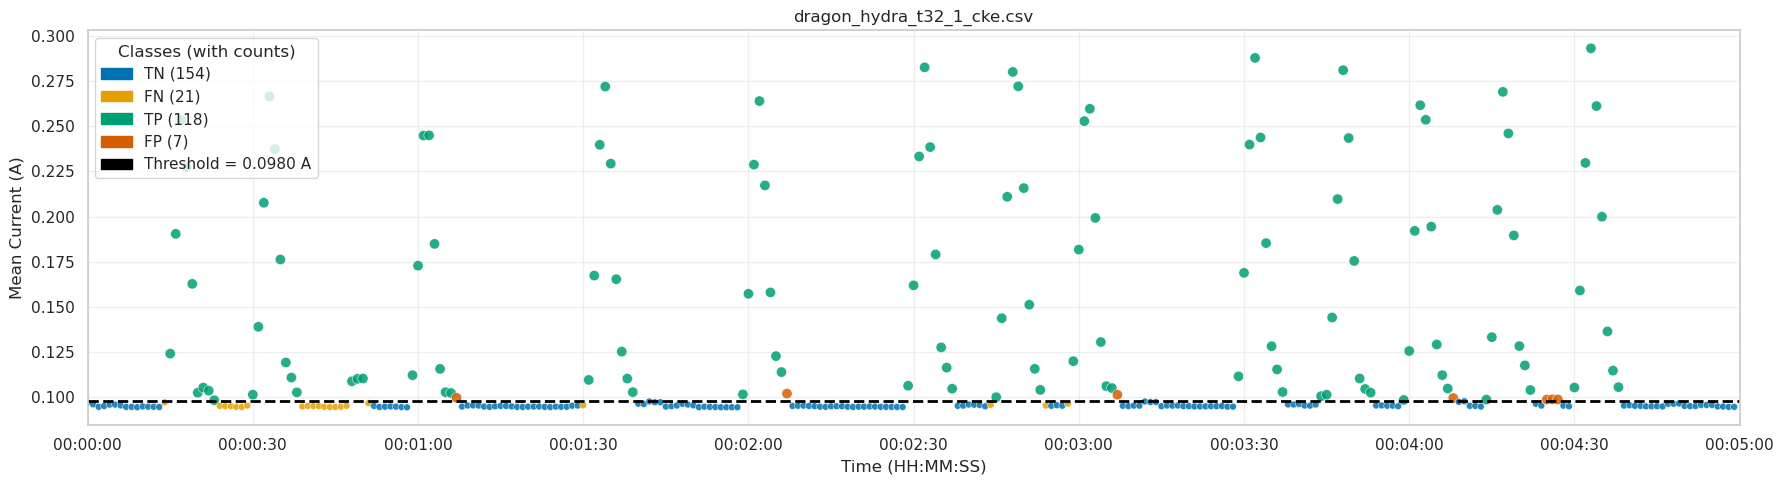


Processing: dragon_hydra_t32_1_ike.csv



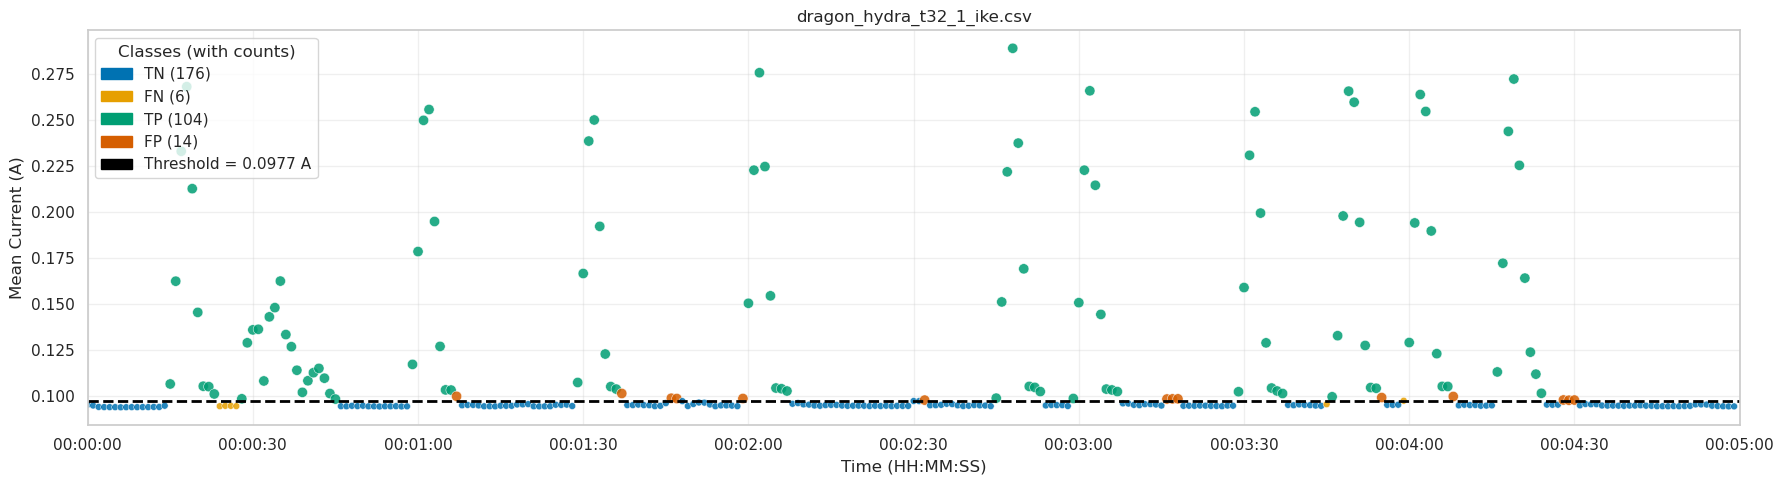


Processing: dragon_hydra_t32_2_cke.csv



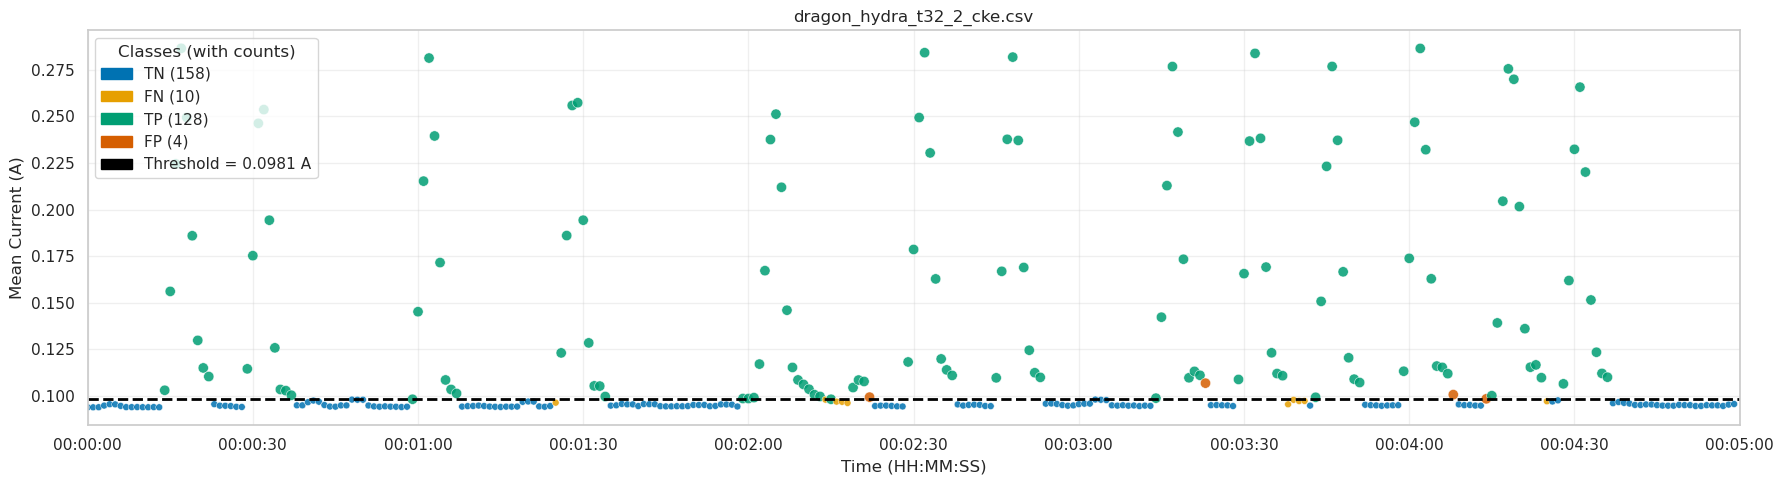


Processing: dragon_hydra_t32_2_ike.csv



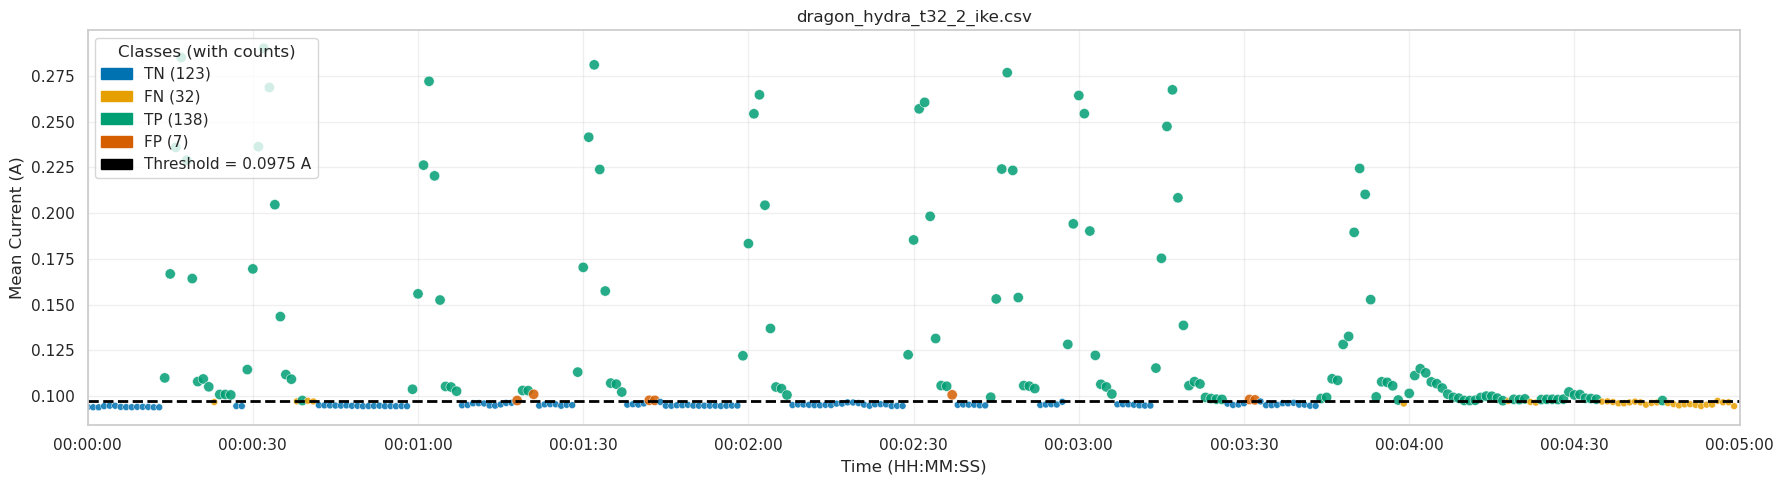


Processing: dragon_hydra_t4_0_ike.csv



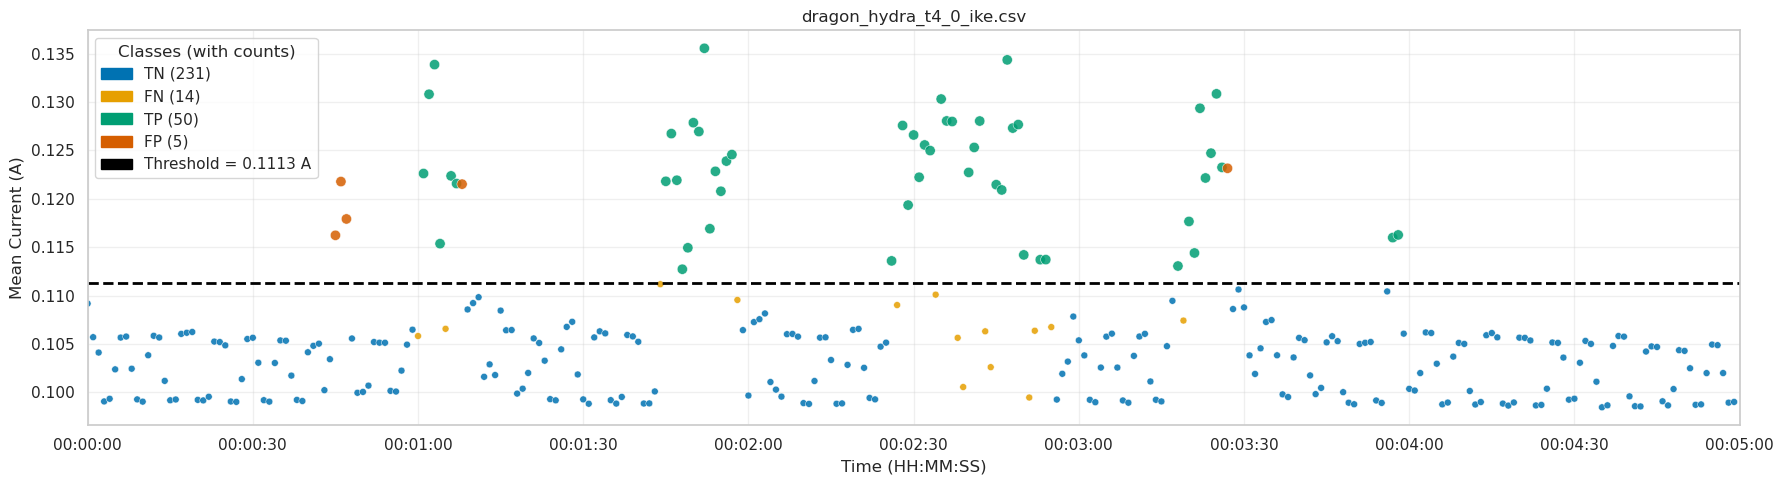


Processing: dragon_hydra_t4_1_cke.csv



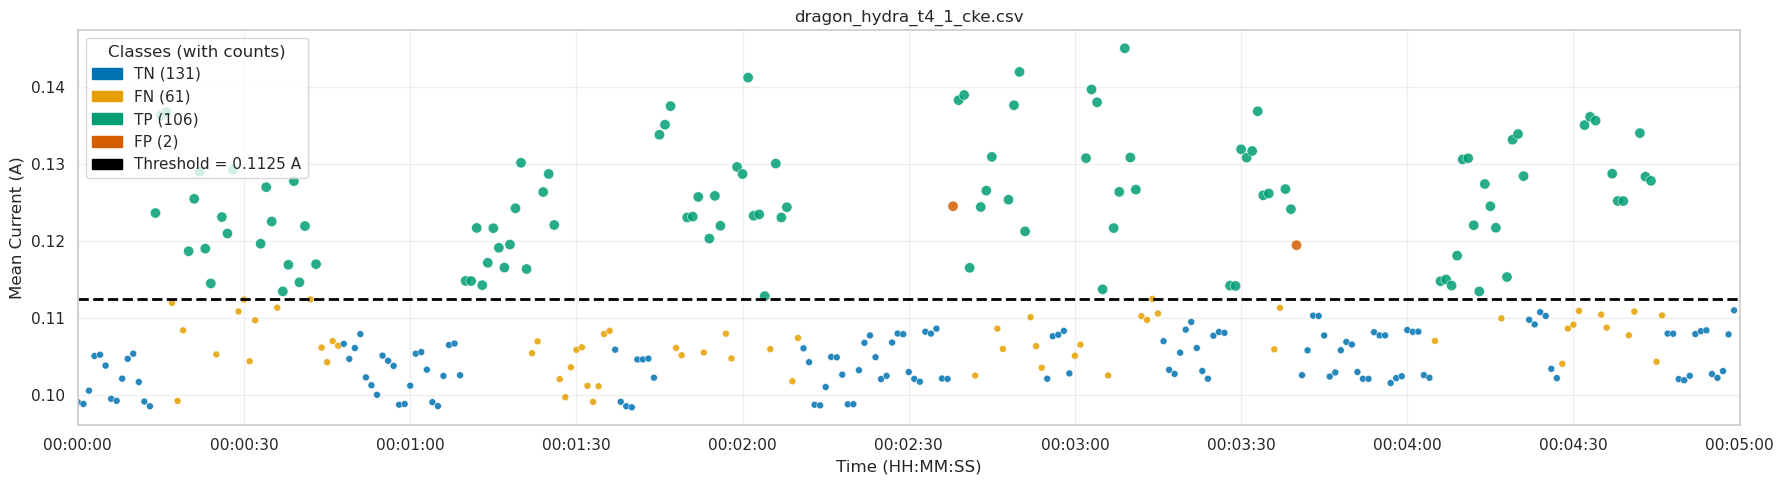


Processing: dragon_hydra_t4_1_ike.csv



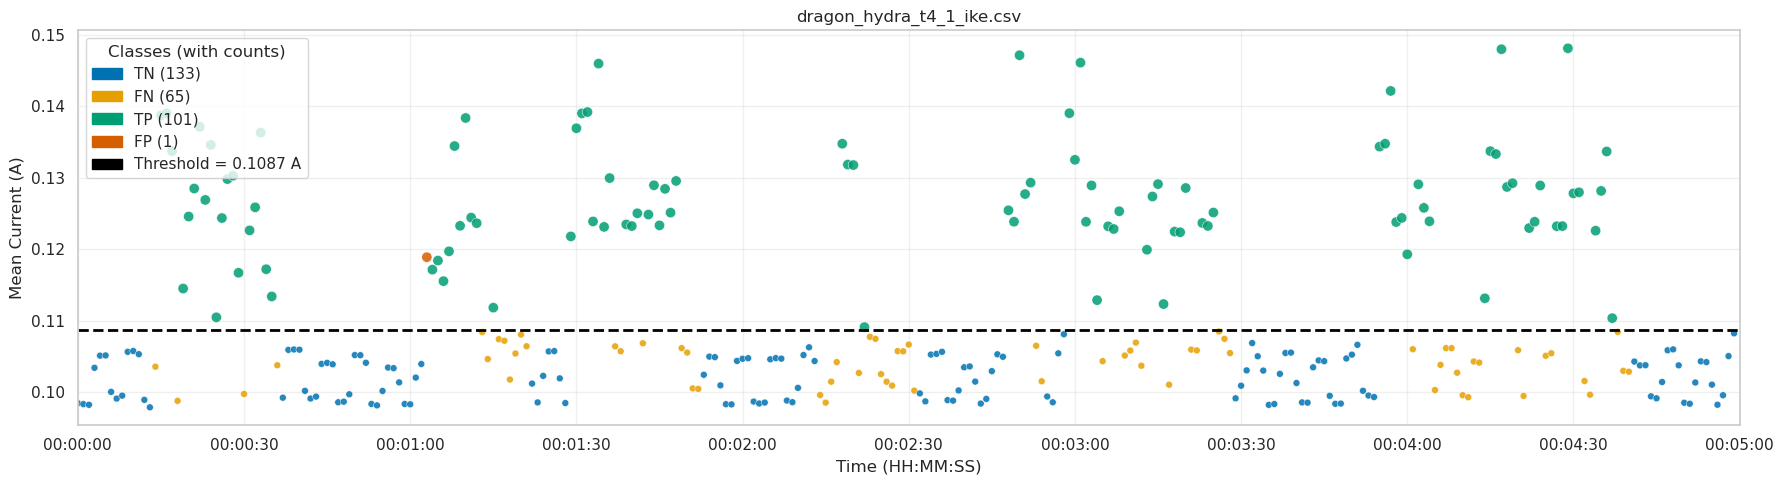


Processing: dragon_hydra_t4_2_cke.csv



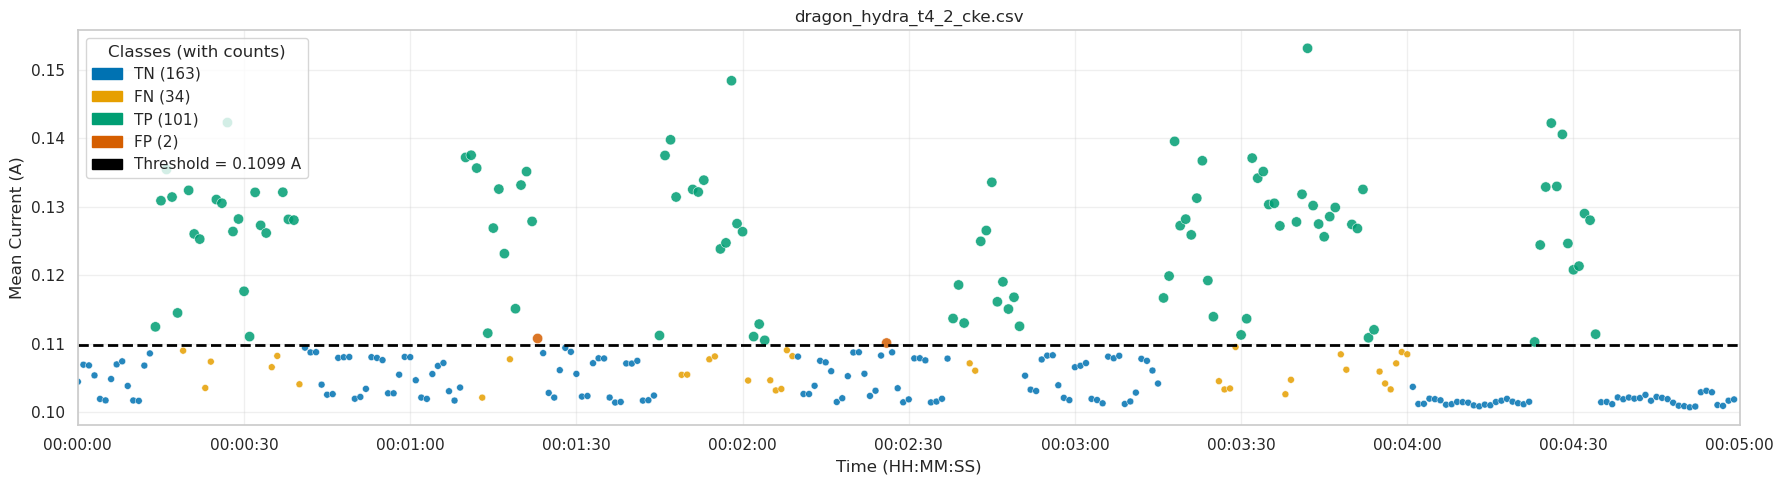


Processing: dragon_hydra_t4_2_ike.csv



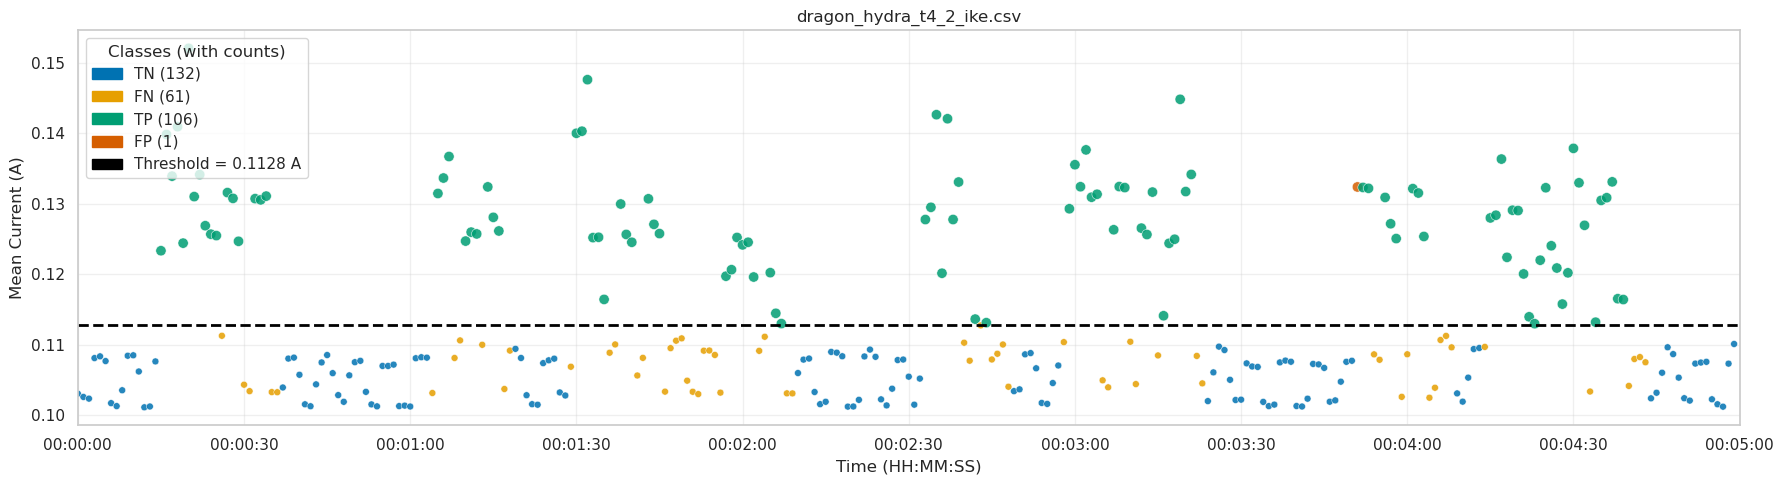


Processing: dragon_hydra_t4_3_cke.csv



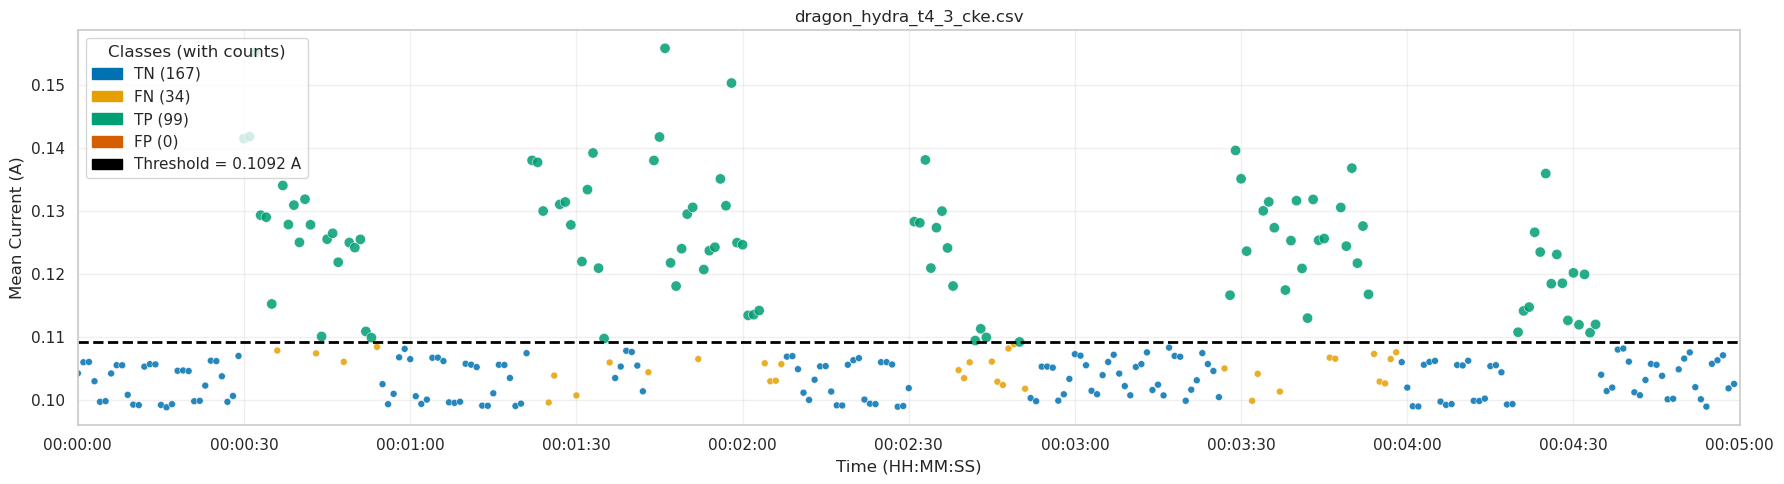


Processing: dragon_hydra_t4_4_cke.csv



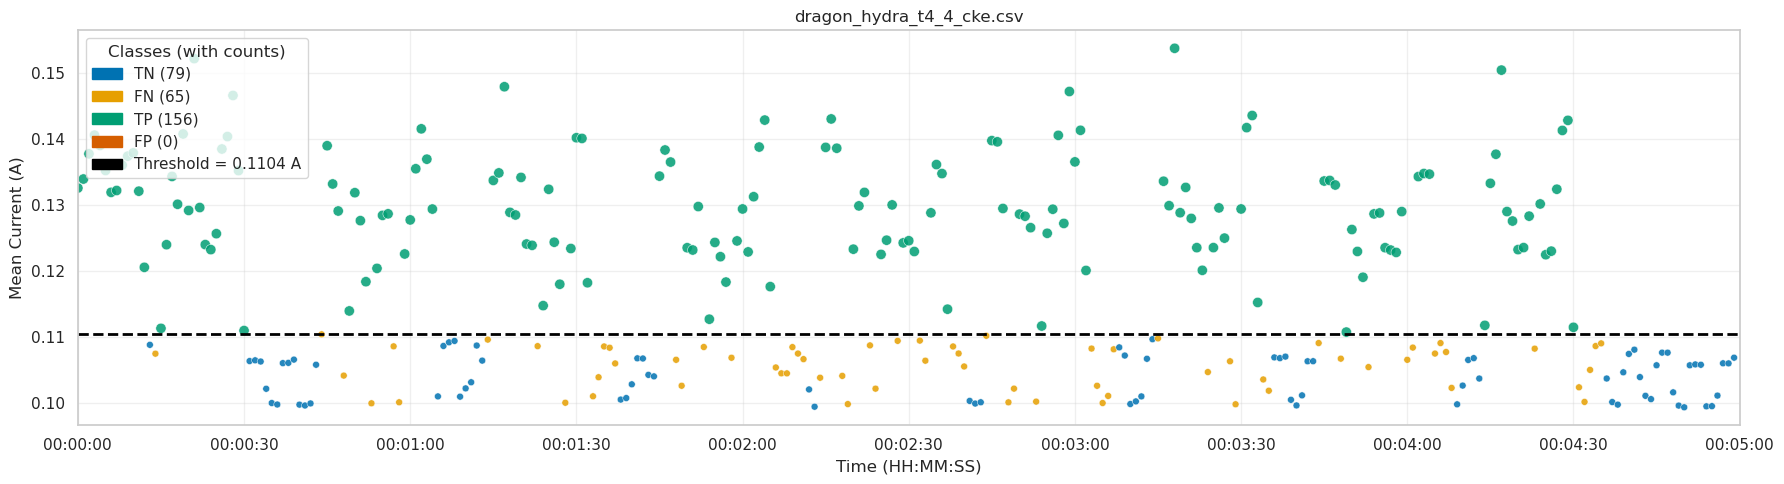


Processing: dragon_hydra_t4_5_cke.csv



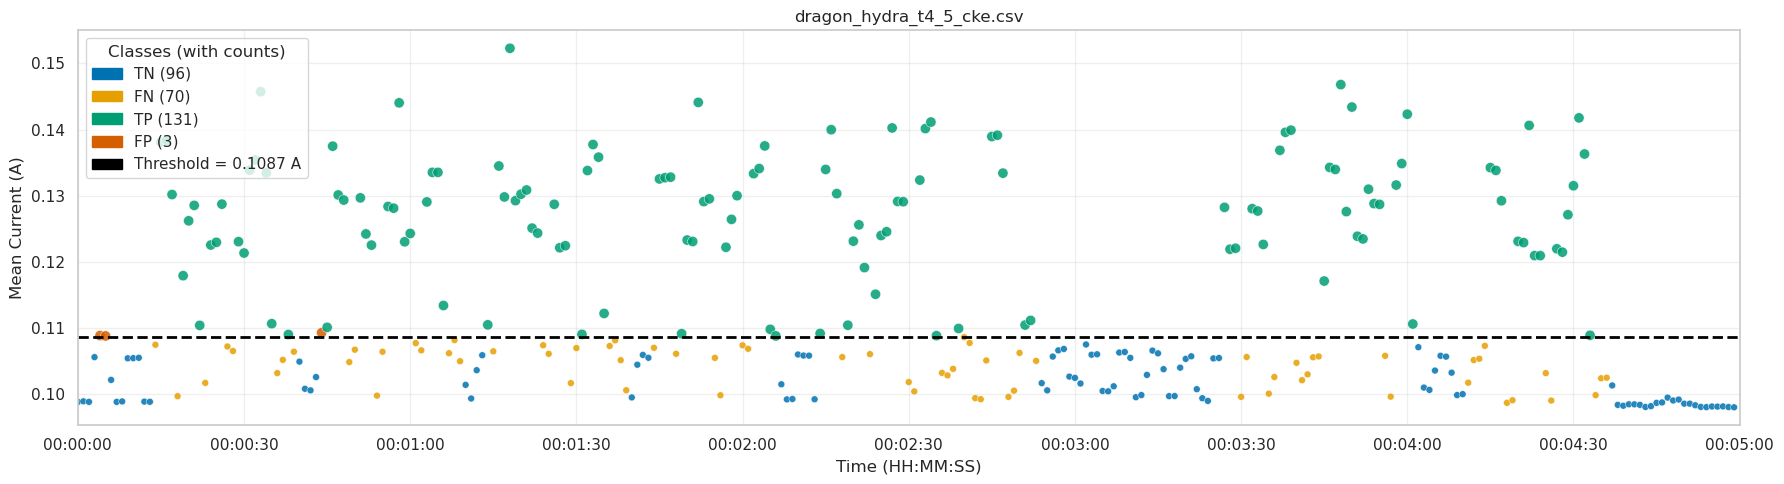


Saved: results_threshold/dragon/dragon_bruteforce_large/summary.csv


filename                           folder   TP  FP   TN  \
0       dragon_hydra_t16_0.csv  /dragon/dragon_bruteforce_large   69   1  218   
1   dragon_hydra_t16_1_cke.csv  /dragon/dragon_bruteforce_large   39   4  183   
2   dragon_hydra_t16_1_ike.csv  /dragon/dragon_bruteforce_large   50   1  174   
3   dragon_hydra_t16_2_cke.csv  /dragon/dragon_bruteforce_large   50   1  180   
4   dragon_hydra_t16_2_ike.csv  /dragon/dragon_bruteforce_large   33   8  185   
5   dragon_hydra_t16_3_cke.csv  /dragon/dragon_bruteforce_large   53   0  162   
6   dragon_hydra_t16_3_ike.csv  /dragon/dragon_bruteforce_large   47   5  211   
7   dragon_hydra_t16_4_cke.csv  /dragon/dragon_bruteforce_large   49   1  167   
8   dragon_hydra_t16_4_ike.csv  /dragon/dragon_bruteforce_large   45   1  155   
9   dragon_hydra_t16_5_cke.csv  /dragon/dragon_bruteforce_large   48   0  181   
10  dragon_hydra_t16_5_ike.csv  /dragon/dragon_bruteforce_large   48   1  172   
11  dragon_hydra_t16_6_cke.csv  /dragon/dragon_bruteforce_large   52   0  176   
12  dragon_hydra_t16_6_ike.csv  /dragon/dragon_bruteforce_large   81   2  134   
13  dragon_hydra_t16_7_cke.csv  /dragon/dragon_bruteforce_large   73   2  148   
14  dragon_hydra_t16_7_ike.csv  /dragon/dragon_bruteforce_large   74   2  151   
15  dragon_hydra_t16_8_cke.csv  /dragon/dragon_bruteforce_large   73   1  150   
16   dragon_hydra_t1_1_cke.csv  /dragon/dragon_bruteforce_large  128   5  129   
17   dragon_hydra_t1_1_ike.csv  /dragon/dragon_bruteforce_large   98   2  153   
18   dragon_hydra_t1_2_cke.csv  /dragon/dragon_bruteforce_large  129   3  127   
19   dragon_hydra_t1_2_ike.csv  /dragon/dragon_bruteforce_large  102   9  165   
20   dragon_hydra_t1_3_ike.csv  /dragon/dragon_bruteforce_large  107   3  133   
21  dragon_hydra_t32_1_cke.csv  /dragon/dragon_bruteforce_large  118   7  154   
22  dragon_hydra_t32_1_ike.csv  /dragon/dragon_bruteforce_large  104  14  176   
23  dragon_hydra_t32_2_cke.csv  /dragon/dragon_bruteforce_large  128   4  158   
24  dragon_hydra_t32_2_ike.csv  /dragon/dragon_bruteforce_large  138   7  123   
25   dragon_hydra_t4_0_ike.csv  /dragon/dragon_bruteforce_large   50   5  231   
26   dragon_hydra_t4_1_cke.csv  /dragon/dragon_bruteforce_large  106   2  131   
27   dragon_hydra_t4_1_ike.csv  /dragon/dragon_bruteforce_large  101   1  133   
28   dragon_hydra_t4_2_cke.csv  /dragon/dragon_bruteforce_large  101   2  163   
29   dragon_hydra_t4_2_ike.csv  /dragon/dragon_bruteforce_large  106   1  132   
30   dragon_hydra_t4_3_cke.csv  /dragon/dragon_bruteforce_large   99   0  167   
31   dragon_hydra_t4_4_cke.csv  /dragon/dragon_bruteforce_large  156   0   79   
32   dragon_hydra_t4_5_cke.csv  /dragon/dragon_bruteforce_large  131   3   96   

    FN  
0   12  
1   14  
2   15  
3    9  
4   14  
5   25  
6   37  
7   23  
8   39  
9   11  
10  19  
11  12  
12  23  
13  17  
14  13  
15  16  
16  38  
17  47  
18  41  
19  24  
20  57  
21  21  
22   6  
23  10  
24  32  
25  14  
26  61  
27  65  
28  34  
29  61  
30  34  
31  65  
32  70

In [ ]:
sns.set(style="whitegrid")

DRAGON_BRUTEFORCE_PATH = Path("../../dragon_pi/dragon/dragon_bruteforce_large")

print("Absolute path:", DRAGON_BRUTEFORCE_PATH.resolve())
print("Exists?", DRAGON_BRUTEFORCE_PATH.exists())
print("CSV files found:", len(list(DRAGON_BRUTEFORCE_PATH.glob('*.csv'))))

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(DRAGON_BRUTEFORCE_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(DRAGON_BRUTEFORCE_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / DRAGON_BRUTEFORCE_PATH.parent.name / DRAGON_BRUTEFORCE_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df


Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/dragon/dragon_ctfs_large
Exists? True
CSV files found: 6

Processing: dragon_ctf_1.csv



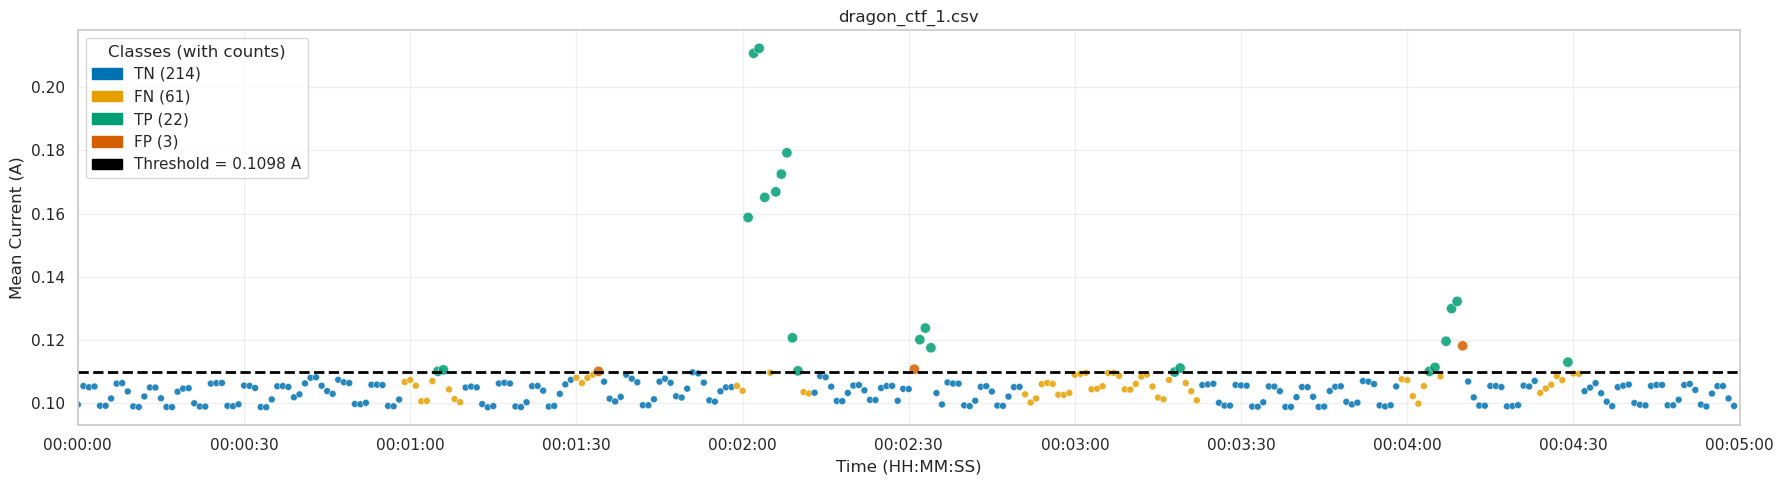


Processing: dragon_ctf_2.csv



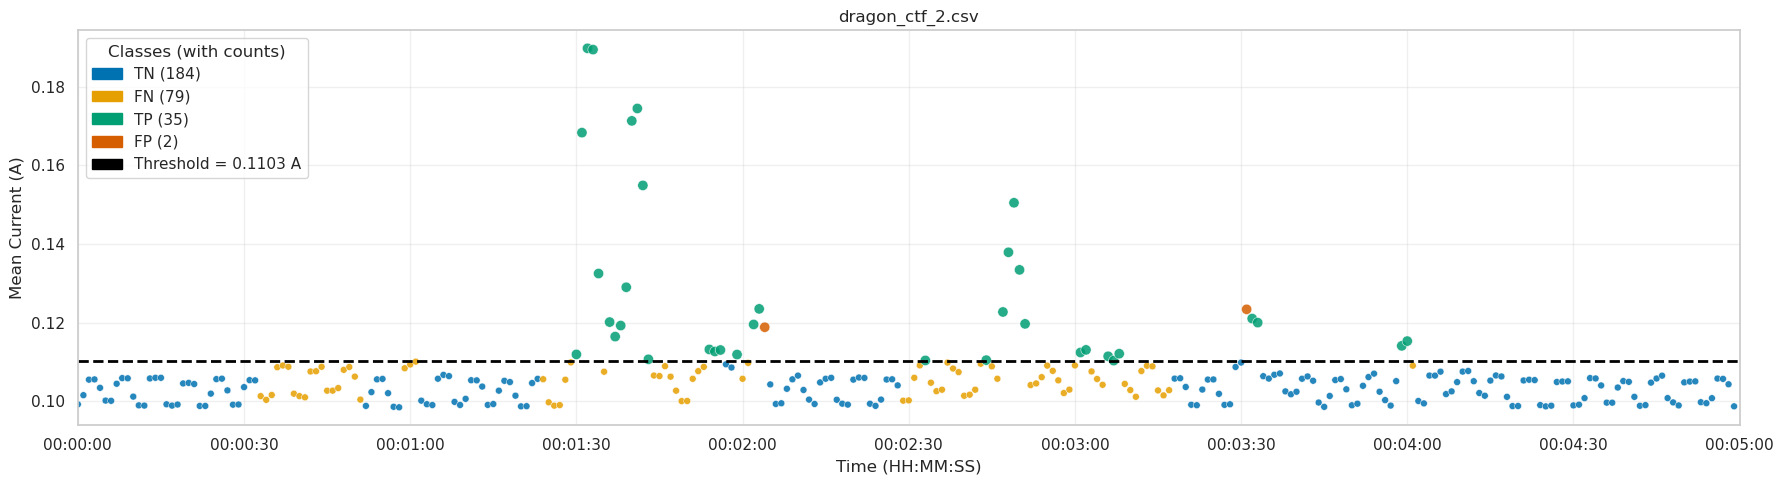


Processing: dragon_ctf_3.csv



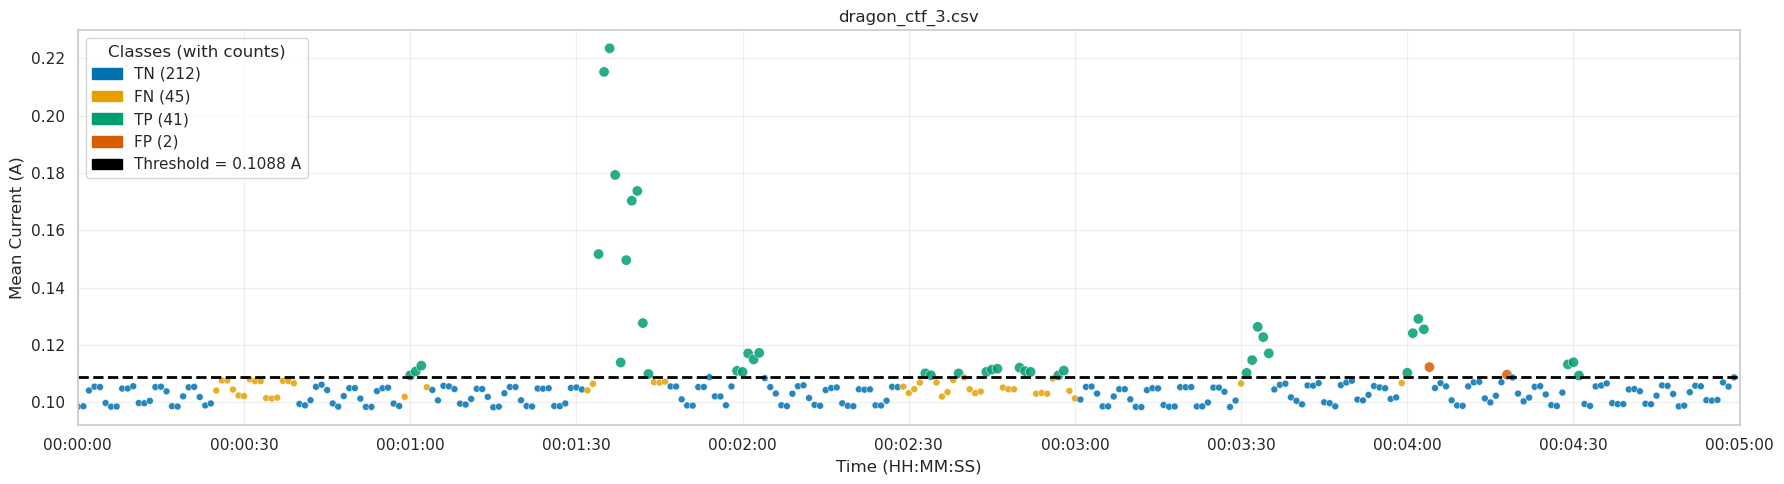


Saved: results_threshold/dragon/dragon_ctfs_large/summary.csv


filename                     folder  TP  FP   TN  FN
0  dragon_ctf_1.csv  /dragon/dragon_ctfs_large  22   3  214  61
1  dragon_ctf_2.csv  /dragon/dragon_ctfs_large  35   2  184  79
2  dragon_ctf_3.csv  /dragon/dragon_ctfs_large  41   2  212  45

In [ ]:
sns.set(style="whitegrid")

DRAGON_CTFS_PATH = Path("../../dragon_pi/dragon/dragon_ctfs_large")

print("Absolute path:", DRAGON_CTFS_PATH.resolve())
print("Exists?", DRAGON_CTFS_PATH.exists())
print("CSV files found:", len(list(DRAGON_CTFS_PATH.glob('*.csv'))))

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(DRAGON_CTFS_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(DRAGON_CTFS_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / DRAGON_CTFS_PATH.parent.name / DRAGON_CTFS_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df


Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/pi/pi_ctfs_large
Exists? True
CSV files found: 10

Processing: pi_ctf_1.csv



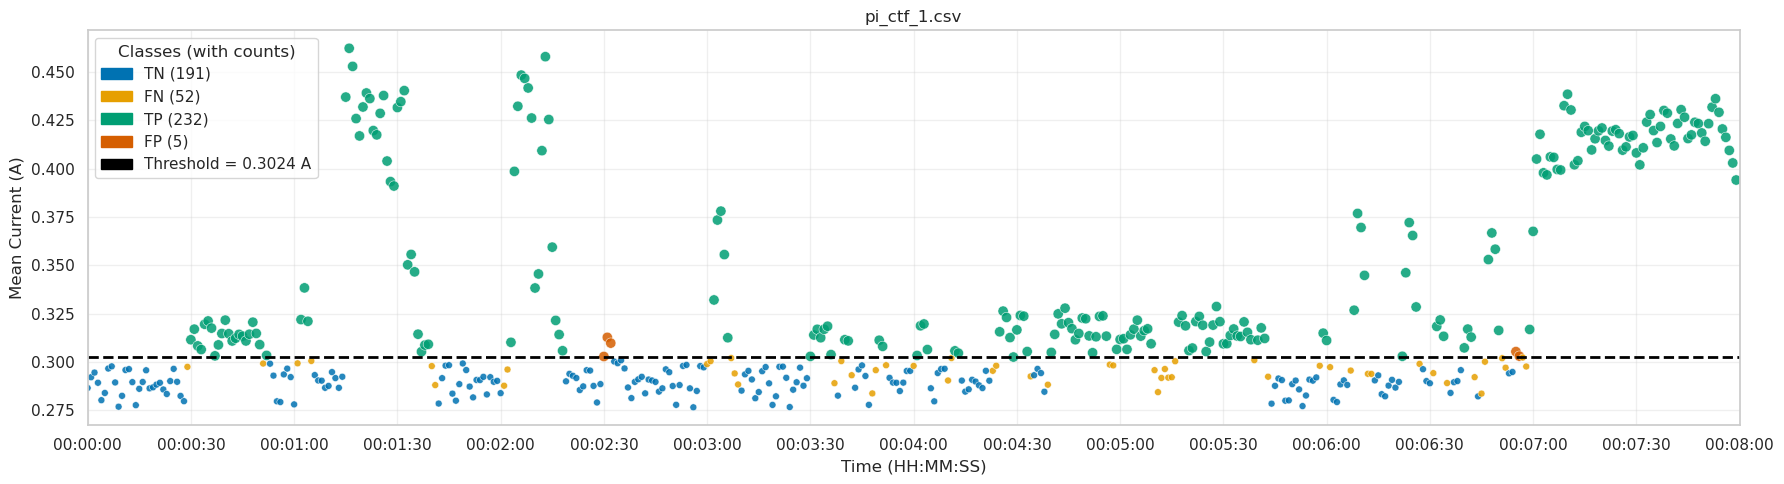


Processing: pi_ctf_2.csv



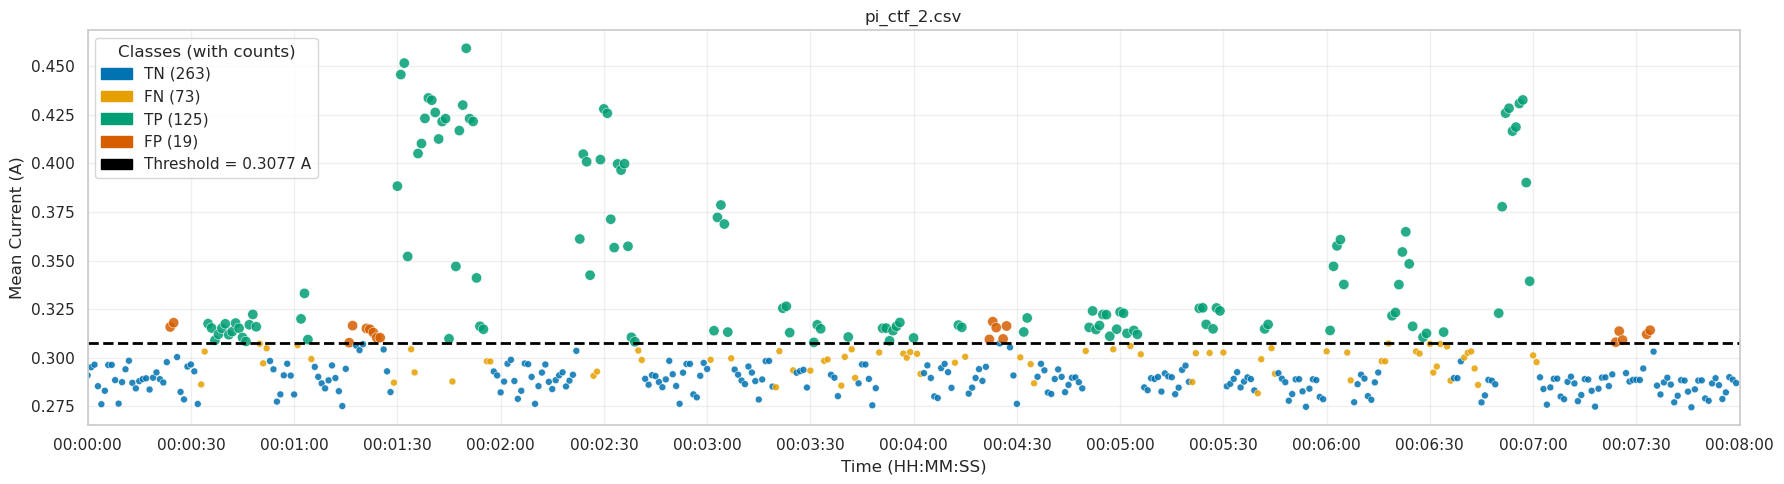


Processing: pi_ctf_3.csv



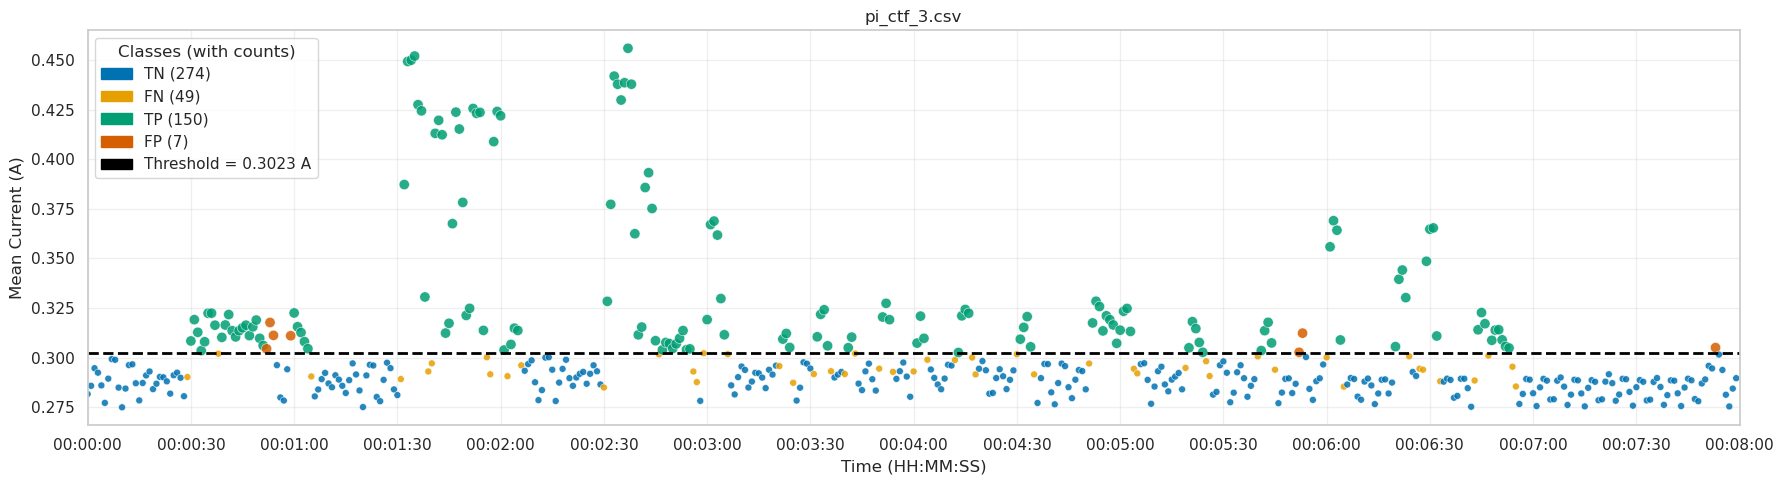


Processing: pi_ctf_4.csv



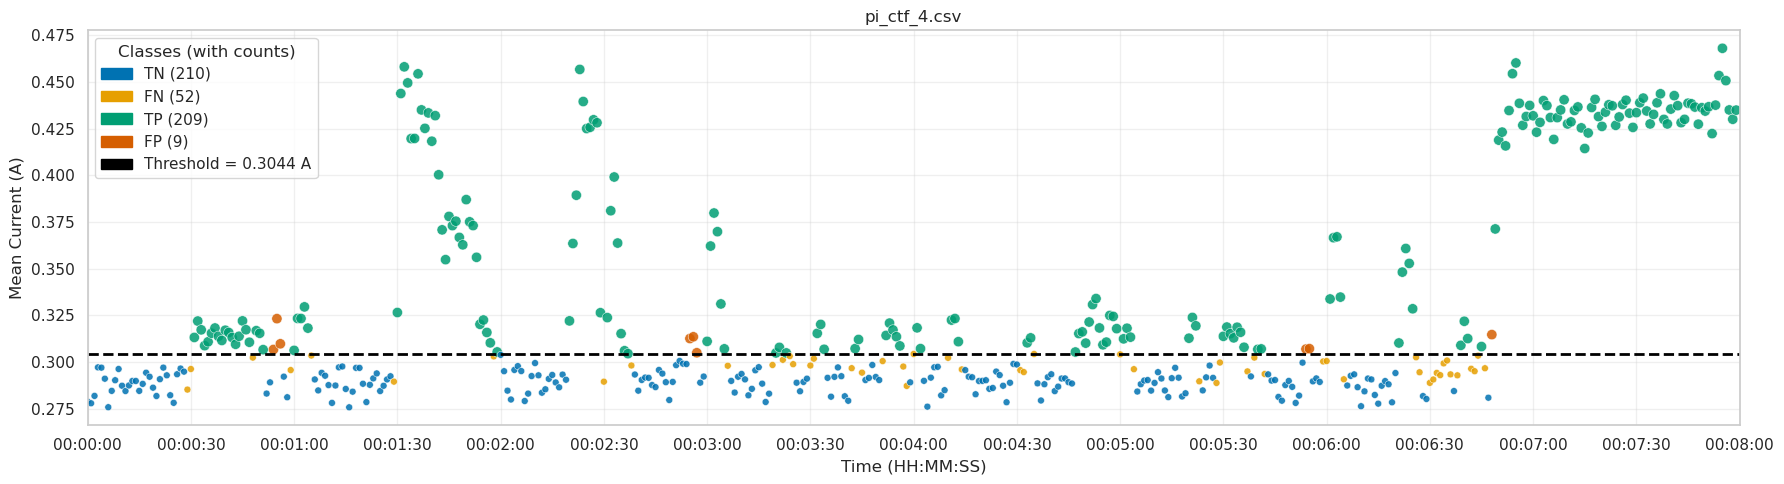


Processing: pi_ctf_5.csv



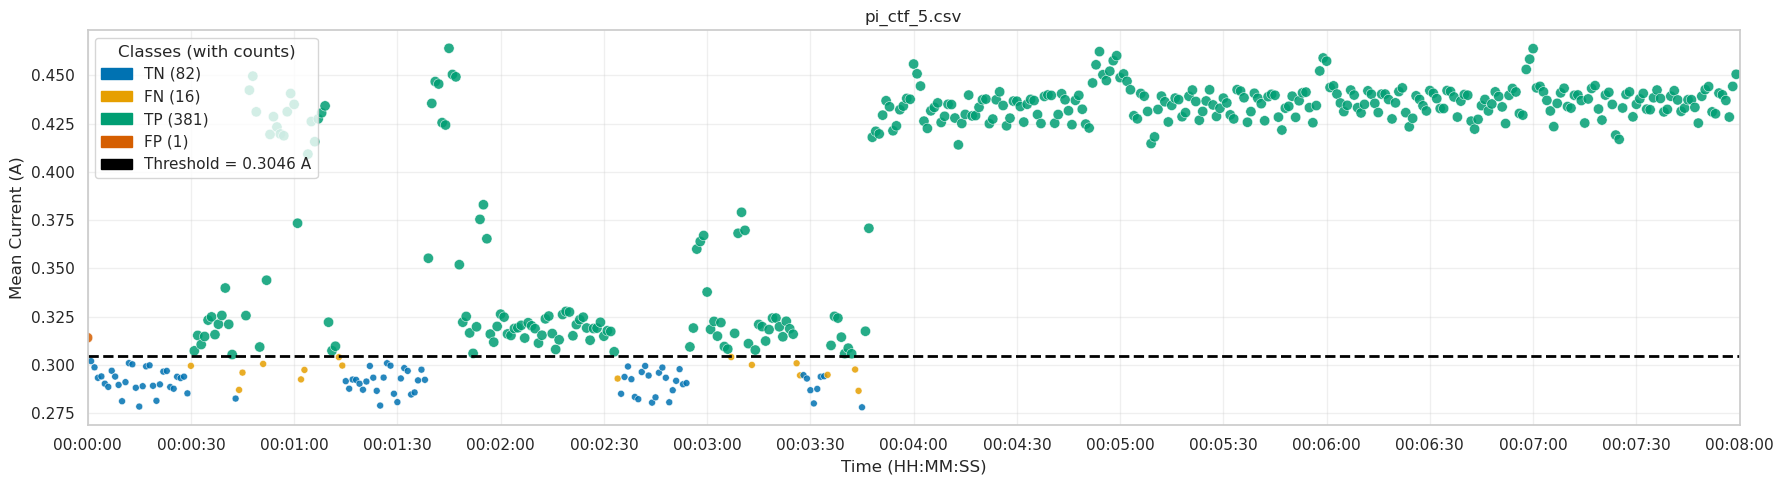


Saved: results_threshold/pi/pi_ctfs_large/summary.csv


filename             folder   TP  FP   TN  FN
0  pi_ctf_1.csv  /pi/pi_ctfs_large  232   5  191  52
1  pi_ctf_2.csv  /pi/pi_ctfs_large  125  19  263  73
2  pi_ctf_3.csv  /pi/pi_ctfs_large  150   7  274  49
3  pi_ctf_4.csv  /pi/pi_ctfs_large  209   9  210  52
4  pi_ctf_5.csv  /pi/pi_ctfs_large  381   1   82  16

In [ ]:
sns.set(style="whitegrid")

PI_CTFS_PATH = Path("../../dragon_pi/pi/pi_ctfs_large")

print("Absolute path:", PI_CTFS_PATH.resolve())
print("Exists?", PI_CTFS_PATH.exists())
print("CSV files found:", len(list(PI_CTFS_PATH.glob('*.csv'))))

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(PI_CTFS_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(PI_CTFS_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / PI_CTFS_PATH.parent.name / PI_CTFS_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df


Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/dragon/dragon_portscan_large
Exists? True
CSV files found: 12

Processing: dragon_nmap_t1.csv



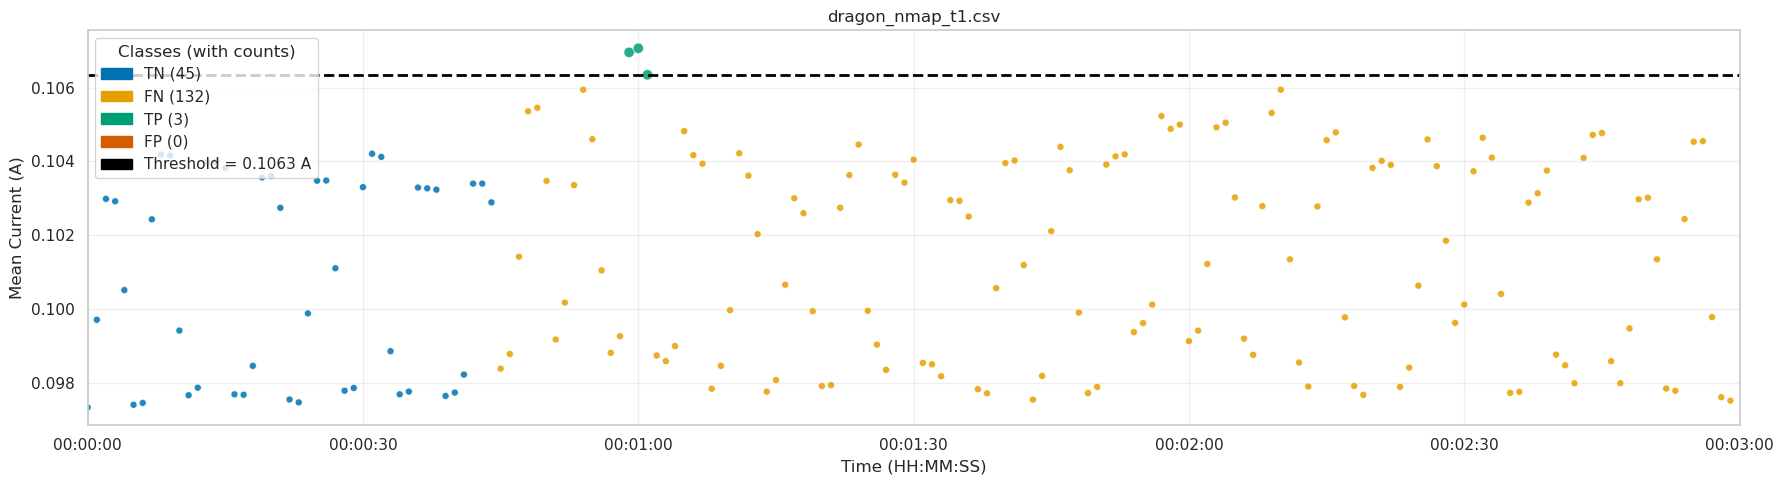


Processing: dragon_nmap_t2.csv



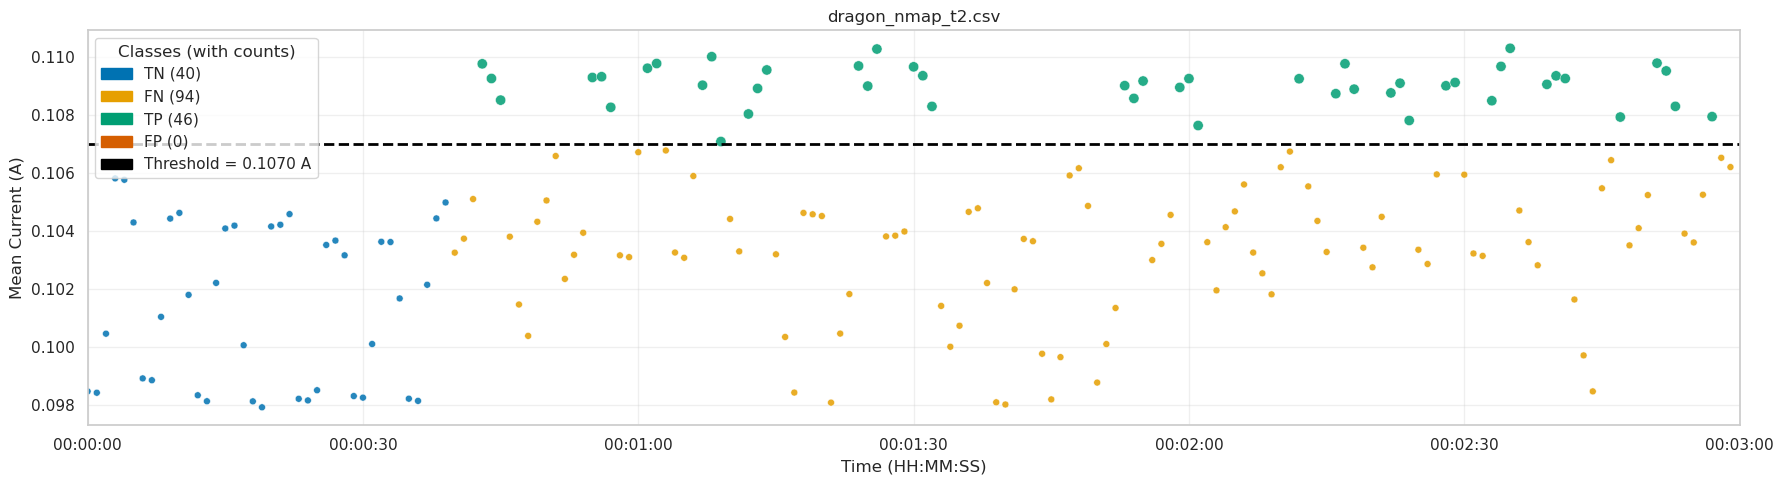


Processing: dragon_nmap_t3_0.csv



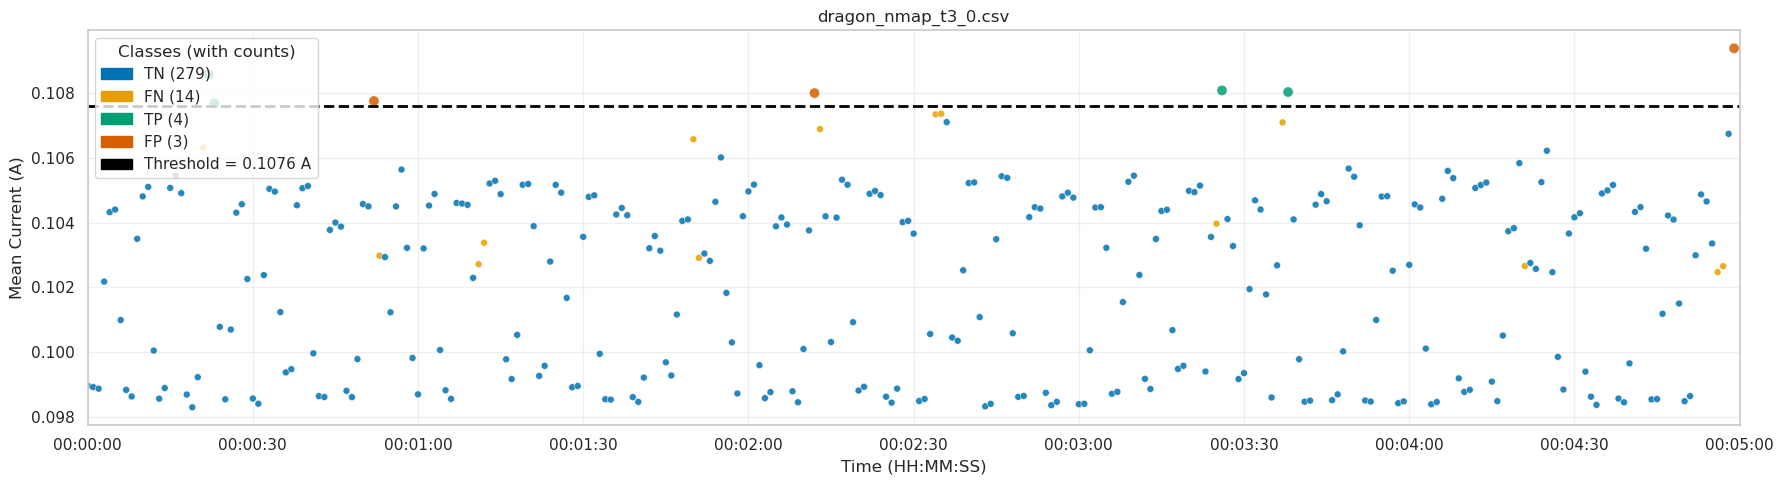


Processing: dragon_nmap_t4.csv



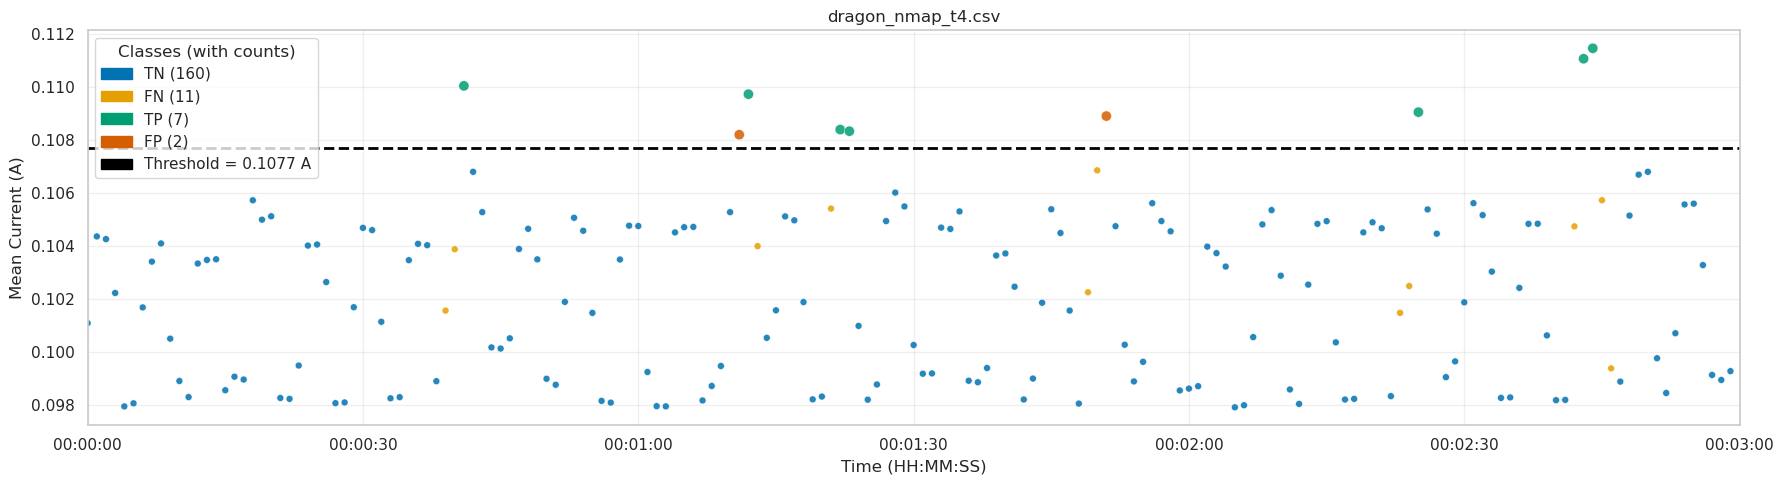


Processing: dragon_nmap_t5_1.csv



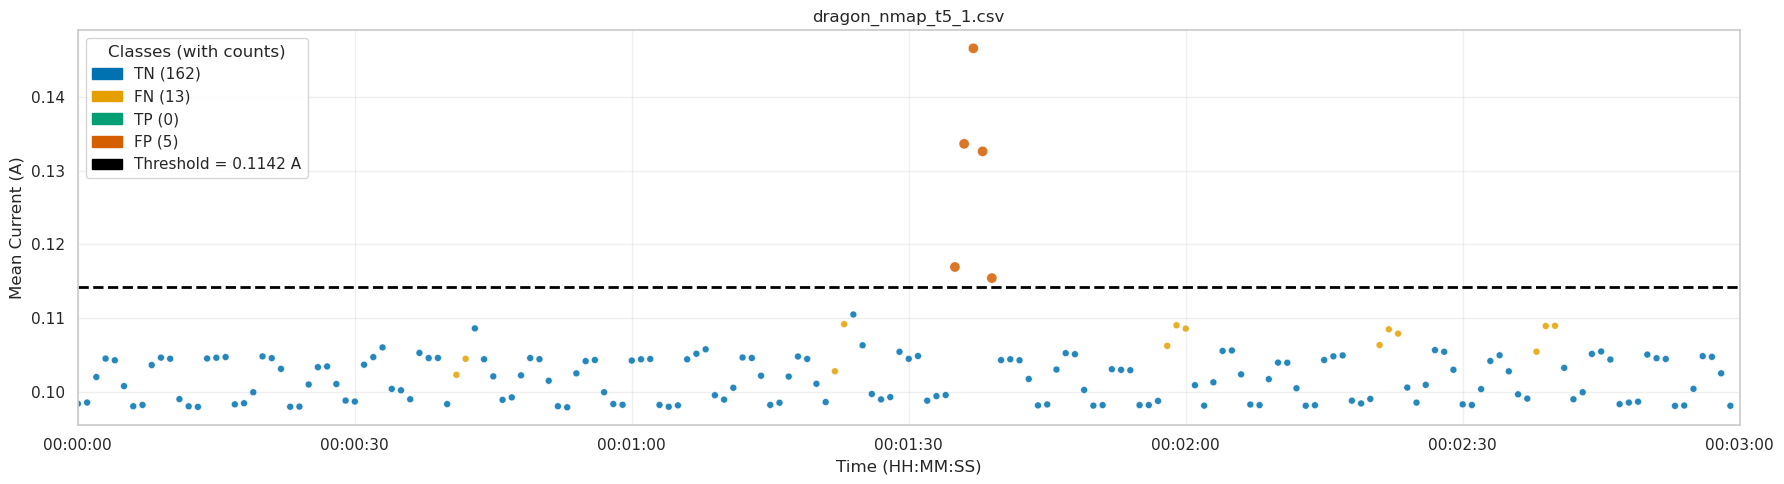


Processing: dragon_nmap_t5_2.csv



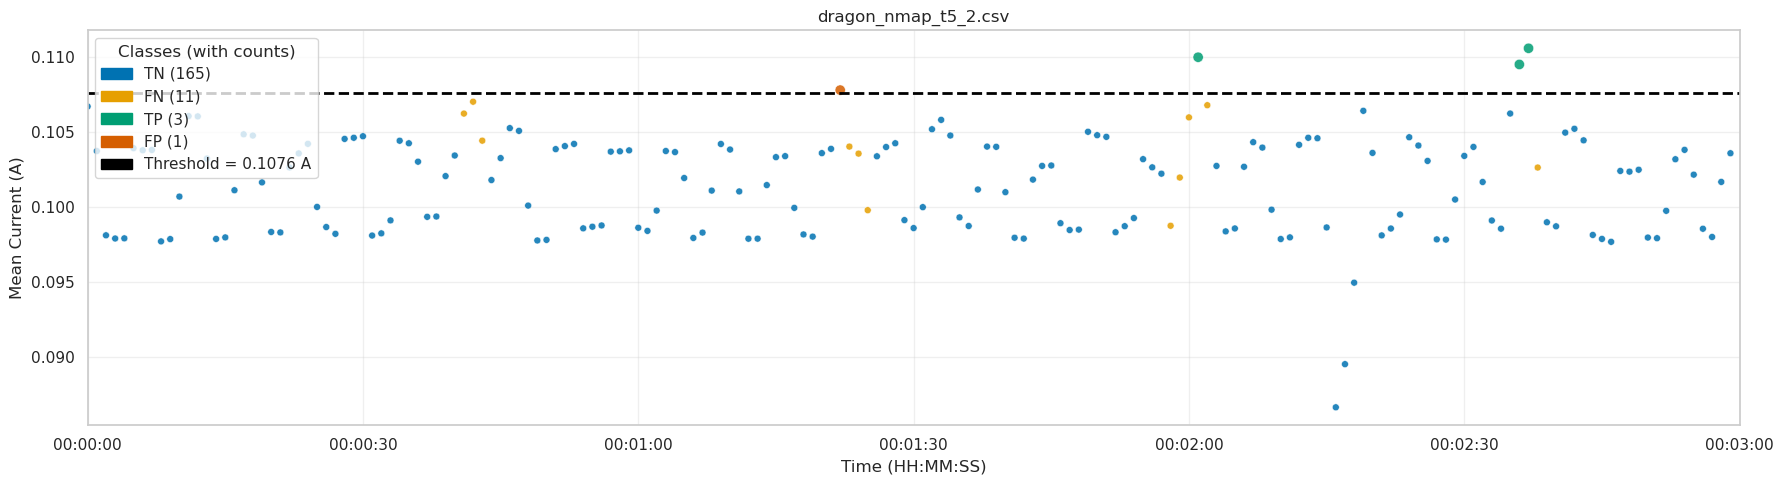


Saved: results_threshold/dragon/dragon_portscan_large/summary.csv


filename                         folder  TP  FP   TN   FN
0    dragon_nmap_t1.csv  /dragon/dragon_portscan_large   3   0   45  132
1    dragon_nmap_t2.csv  /dragon/dragon_portscan_large  46   0   40   94
2  dragon_nmap_t3_0.csv  /dragon/dragon_portscan_large   4   3  279   14
3    dragon_nmap_t4.csv  /dragon/dragon_portscan_large   7   2  160   11
4  dragon_nmap_t5_1.csv  /dragon/dragon_portscan_large   0   5  162   13
5  dragon_nmap_t5_2.csv  /dragon/dragon_portscan_large   3   1  165   11

In [ ]:
sns.set(style="whitegrid")

DRAGON_PORTSCAN_PATH = Path("../../dragon_pi/dragon/dragon_portscan_large")

print("Absolute path:", DRAGON_PORTSCAN_PATH.resolve())
print("Exists?", DRAGON_PORTSCAN_PATH.exists())
print("CSV files found:", len(list(DRAGON_PORTSCAN_PATH.glob('*.csv'))))

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(DRAGON_PORTSCAN_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(DRAGON_PORTSCAN_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / DRAGON_PORTSCAN_PATH.parent.name / DRAGON_PORTSCAN_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df


Absolute path: /home/edllyn/Downloads/QUALI - EDA /iot-energy-ml/dragon_pi/pi/pi_portscan_large
Exists? True
CSV files found: 18

Processing: pi_nmap_t0_1.csv



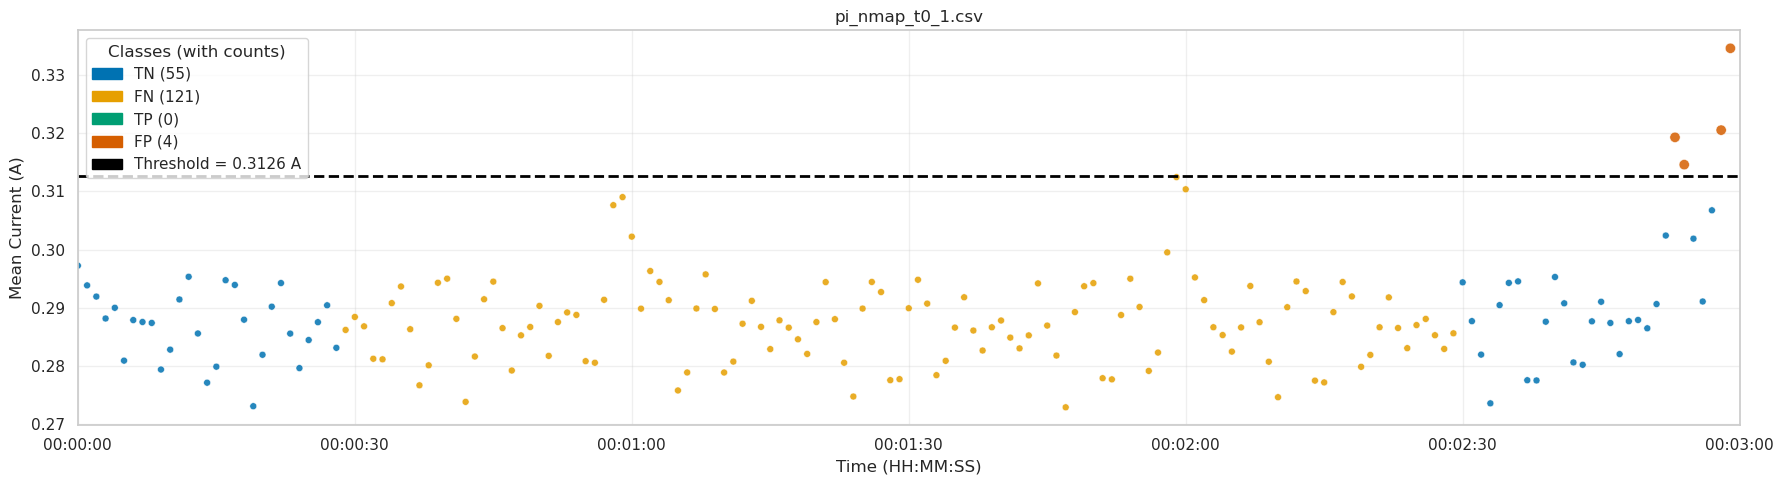


Processing: pi_nmap_t0_2.csv



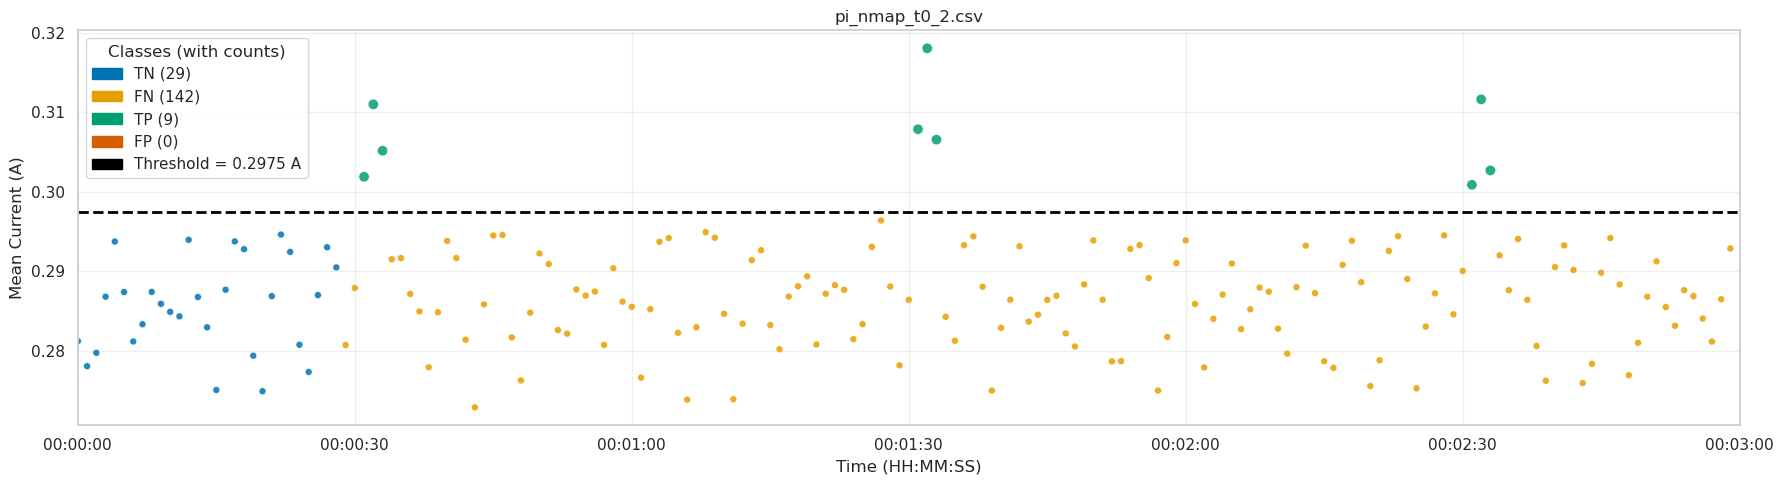


Processing: pi_nmap_t0_3.csv



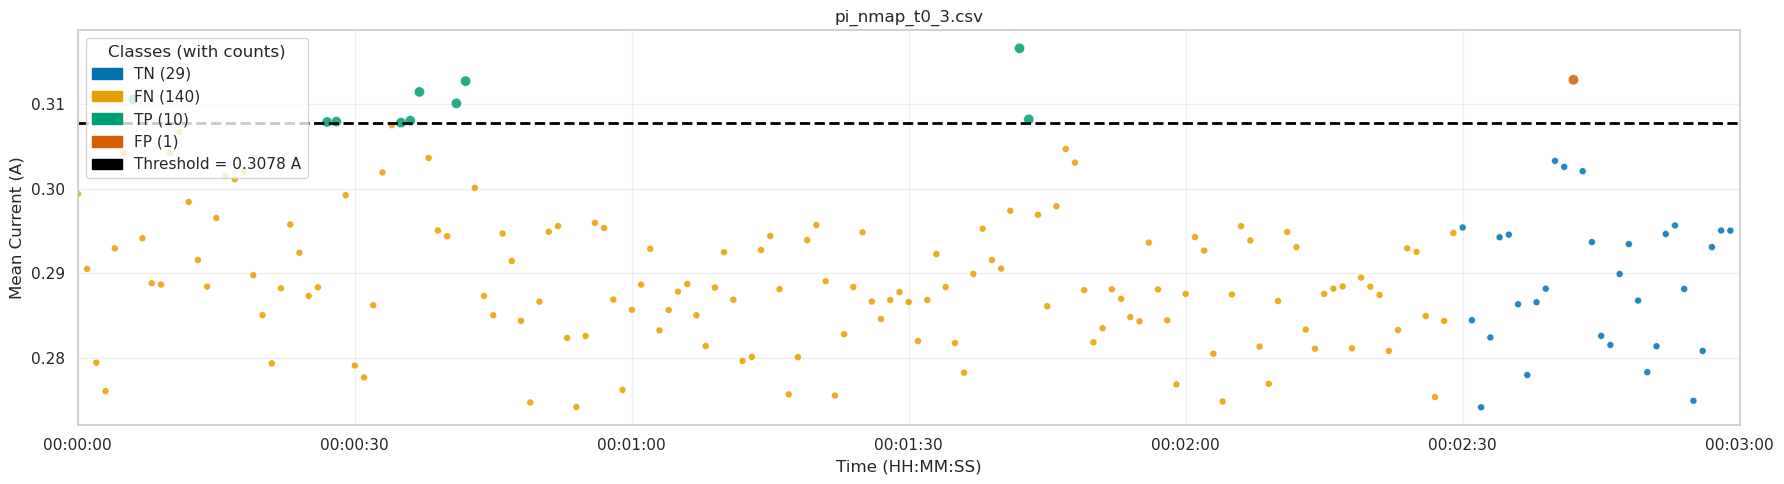


Processing: pi_nmap_t0_4.csv



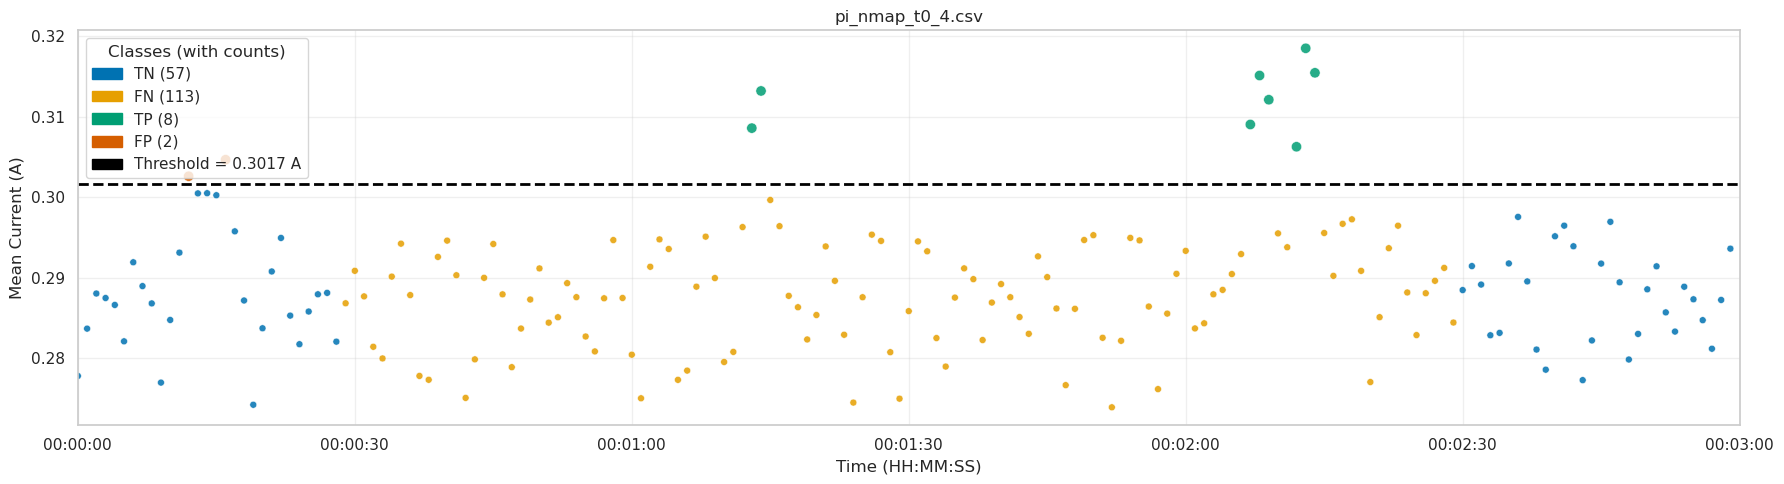


Processing: pi_nmap_t1.csv



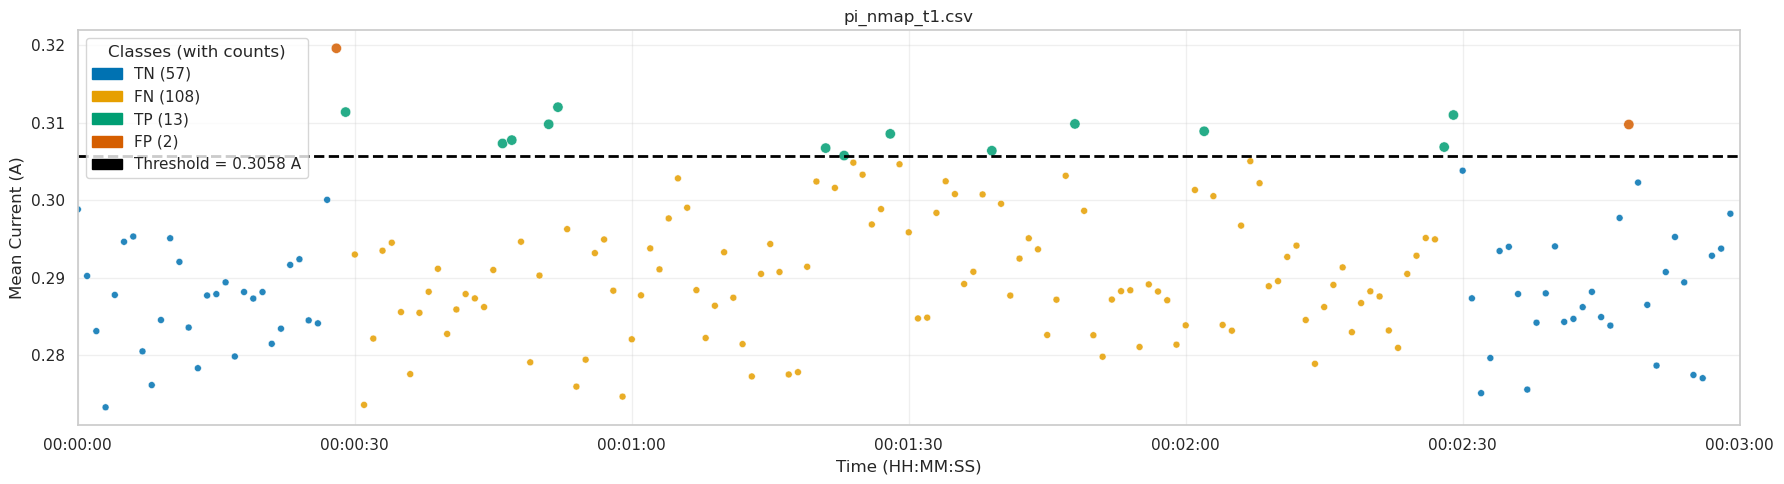


Processing: pi_nmap_t2.csv



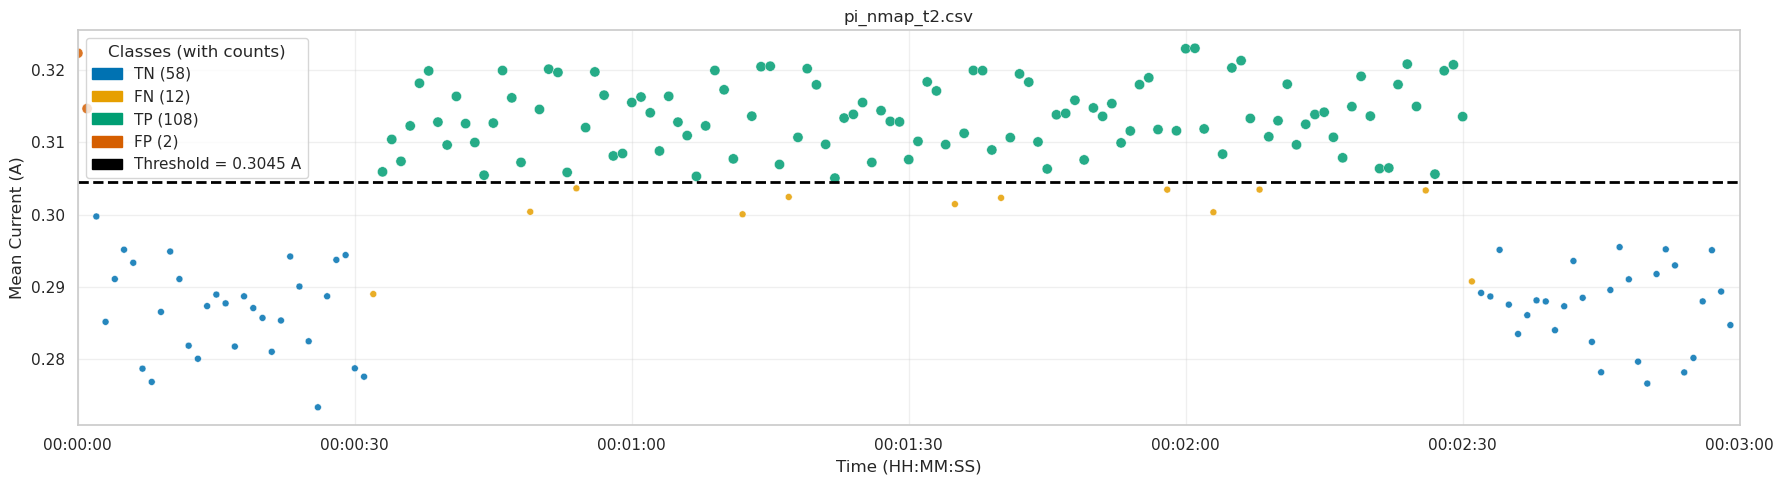


Processing: pi_nmap_t3.csv



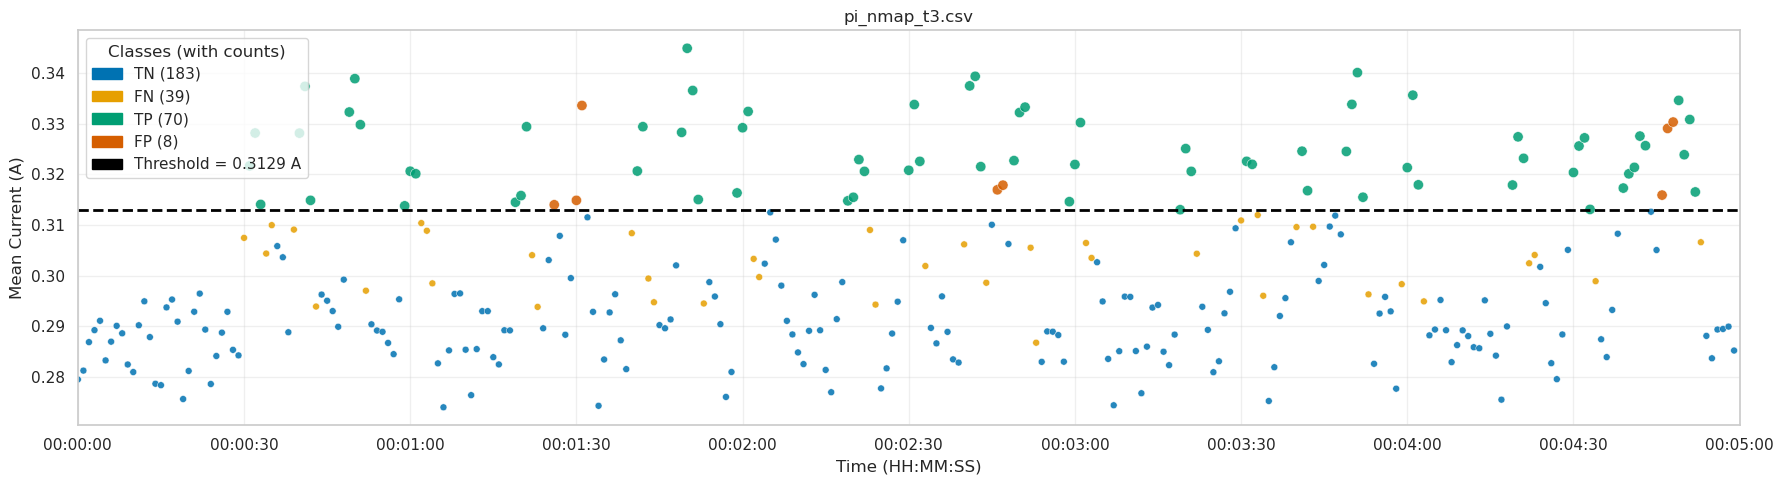


Processing: pi_nmap_t4.csv



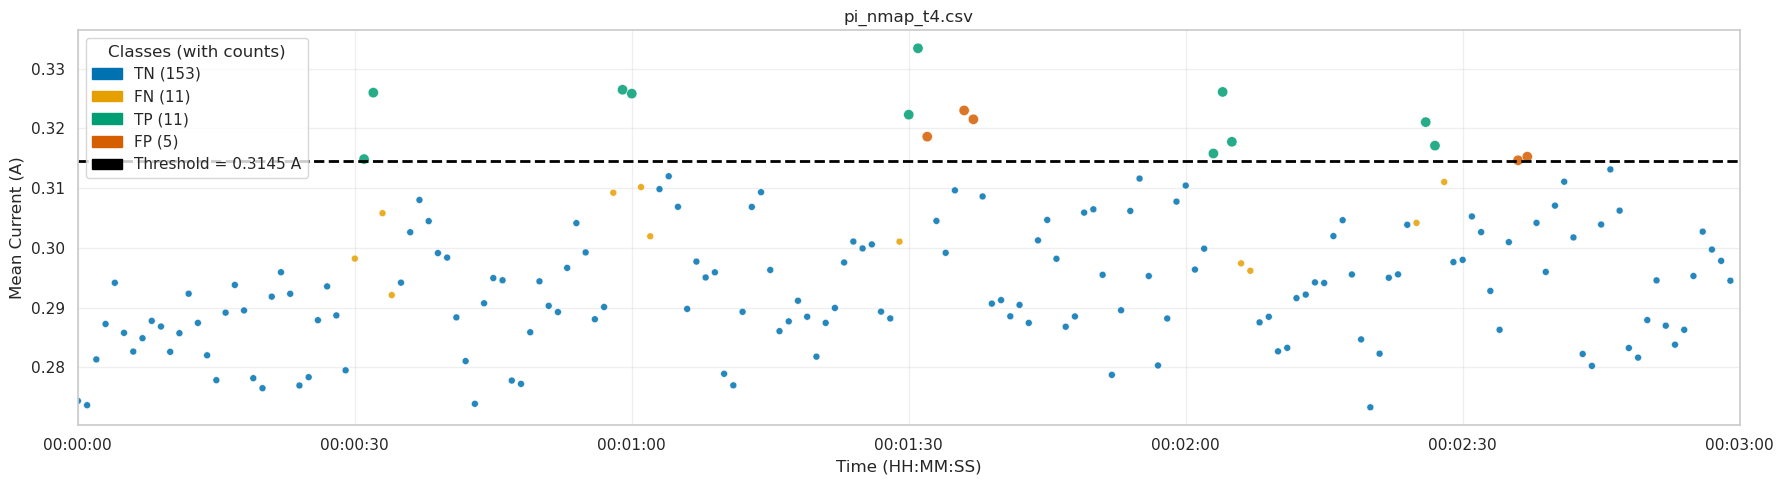


Processing: pi_nmap_t5.csv



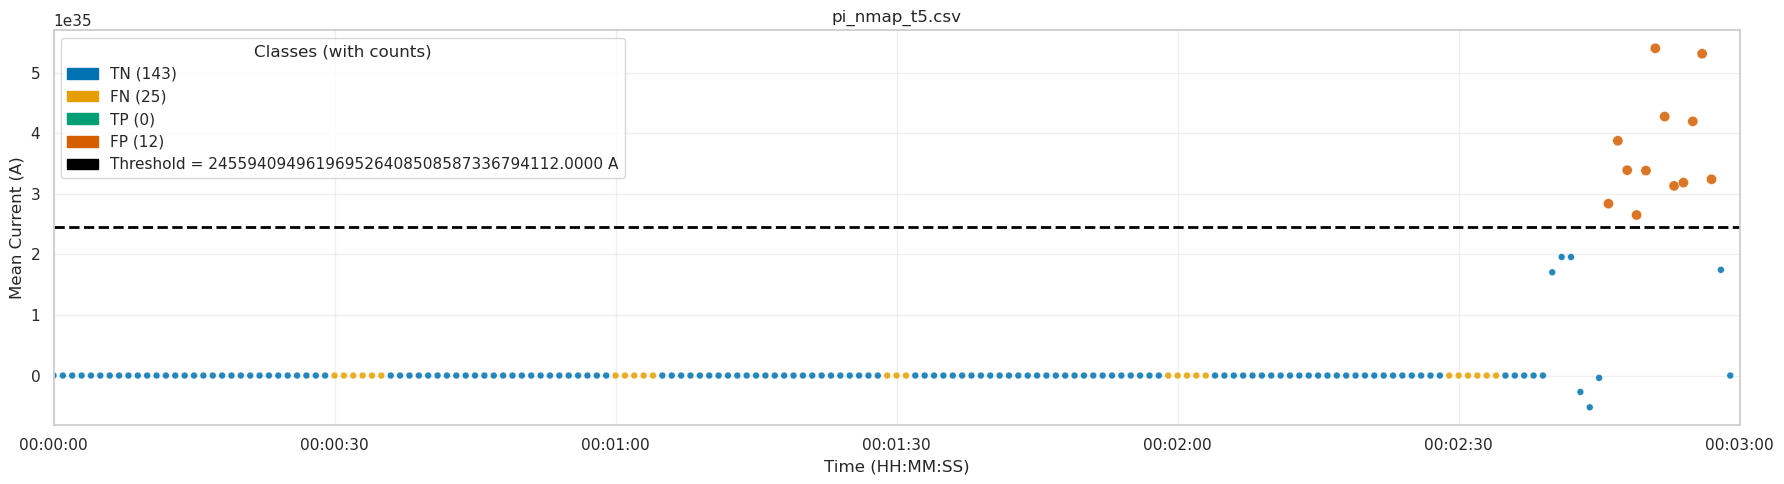


Saved: results_threshold/pi/pi_portscan_large/summary.csv


filename                 folder   TP  FP   TN   FN
0  pi_nmap_t0_1.csv  /pi/pi_portscan_large    0   4   55  121
1  pi_nmap_t0_2.csv  /pi/pi_portscan_large    9   0   29  142
2  pi_nmap_t0_3.csv  /pi/pi_portscan_large   10   1   29  140
3  pi_nmap_t0_4.csv  /pi/pi_portscan_large    8   2   57  113
4    pi_nmap_t1.csv  /pi/pi_portscan_large   13   2   57  108
5    pi_nmap_t2.csv  /pi/pi_portscan_large  108   2   58   12
6    pi_nmap_t3.csv  /pi/pi_portscan_large   70   8  183   39
7    pi_nmap_t4.csv  /pi/pi_portscan_large   11   5  153   11
8    pi_nmap_t5.csv  /pi/pi_portscan_large    0  12  143   25

In [ ]:
sns.set(style="whitegrid")

PI_PORTSCAN_PATH = Path("../../dragon_pi/pi/pi_portscan_large")

print("Absolute path:", PI_PORTSCAN_PATH.resolve())
print("Exists?", PI_PORTSCAN_PATH.exists())
print("CSV files found:", len(list(PI_PORTSCAN_PATH.glob('*.csv'))))

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

summary_rows = []

for csv_file in sorted(PI_PORTSCAN_PATH.glob("*.csv")):

    if "_legend" in csv_file.name.lower():
        continue

    print("\n=======================================")
    print(f"Processing: {csv_file.name}")
    print("=======================================\n")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    # Ensure annotation columns exist
    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    # True attack label
    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    summary_rows.append({
        "filename": csv_file.name,
        "folder": str(csv_file.parent).replace(str(PI_PORTSCAN_PATH.parent.parent), ""),
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
    })

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    palette = {
        "TP": "#009E73",
        "FP": "#D55E00",
        "TN": "#0072B2",
        "FN": "#E69F00",
    }

    sizes = {
        "TP": 55,
        "FP": 55,
        "TN": 25,
        "FN": 25,
    }

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(
        threshold,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black", label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(
        handles=legend_handles,
        title="Classes (with counts)",
        frameon=True,
        loc="upper left"
    )

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{csv_file.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

output_dir = Path("results_threshold") / PI_PORTSCAN_PATH.parent.name / PI_PORTSCAN_PATH.name
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / "summary.csv"

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(output_file, index=False)

print("\nSaved:", output_file)
summary_df



Processing: Dragon — dragon_synflood.csv



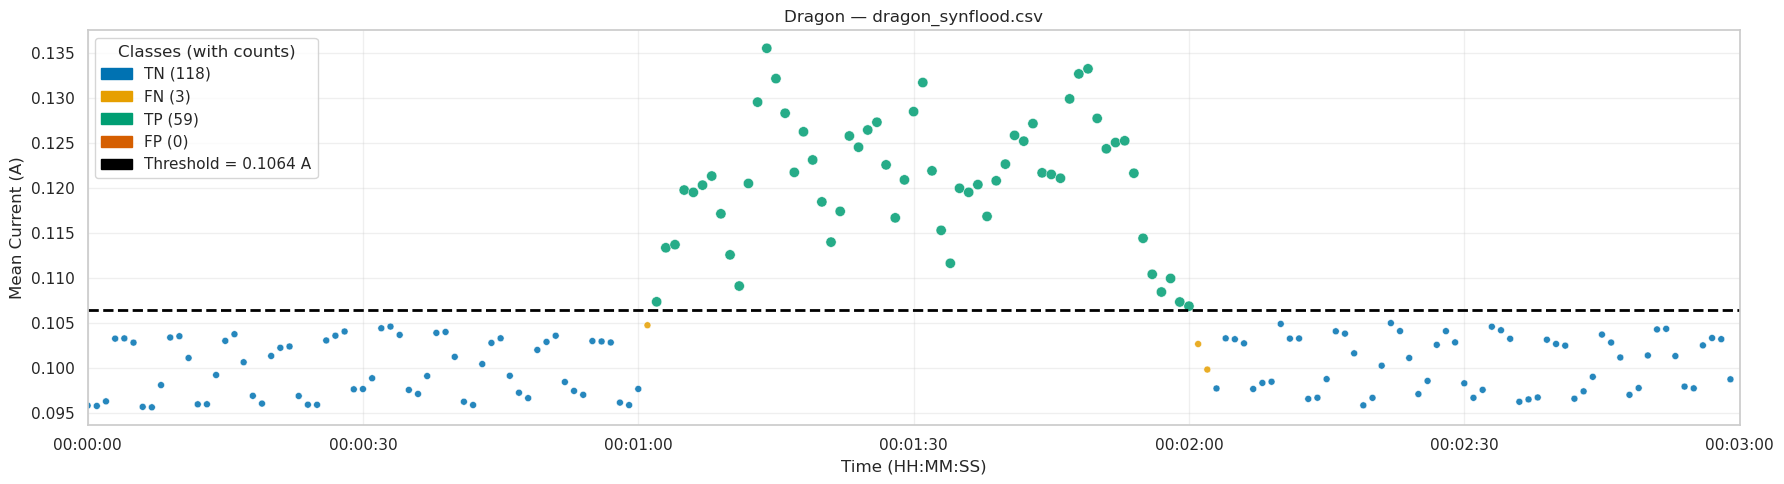

Saved: results_threshold/dragon/dragon_dos_large/summary.csv

Processing: Pi — pi_synflood.csv



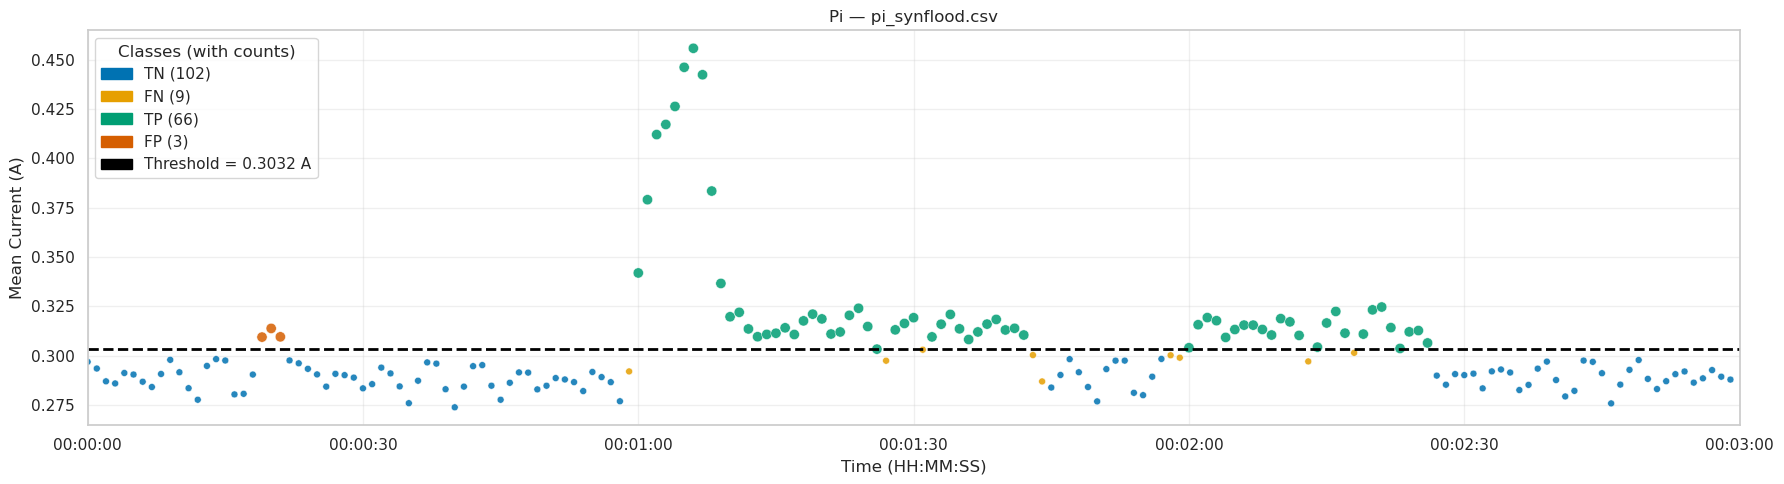

Saved: results_threshold/pi/pi_dos_large/summary.csv


In [ ]:
sns.set(style="whitegrid")

DATASETS = {
    "Dragon": Path("../../dragon_pi/dragon/dragon_dos_large/dragon_synflood.csv"),
    "Pi":     Path("../../dragon_pi/pi/pi_dos_large/pi_synflood.csv")
}

START_DATE = pd.to_datetime("2012-02-29 00:00:00")

palette = {
    "TP": "#009E73",
    "FP": "#D55E00",
    "TN": "#0072B2",
    "FN": "#E69F00",
}

sizes = {
    "TP": 55,
    "FP": 55,
    "TN": 25,
    "FN": 25,
}

for device_name, file_path in DATASETS.items():

    print("\n=======================================")
    print(f"Processing: {device_name} — {file_path.name}")
    print("=======================================\n")

    df = pd.read_csv(file_path, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df.resample("1s")
          .agg({"Current": "mean", "is_attack": "max"})
          .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec["Current"].rolling(3, min_periods=1, center=True).mean()
    )

    normal_mask = df_sec["is_attack"] == False
    normal_mean = df_sec.loc[normal_mask, "Corrente (A)"].mean()
    normal_std  = df_sec.loc[normal_mask, "Corrente (A)"].std()

    threshold = normal_mean + 2 * normal_std

    df_sec["y_true"] = df_sec["is_attack"].astype(int)
    df_sec["y_pred"] = (df_sec["Corrente (A)"] > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(df_sec["y_true"], df_sec["y_pred"]).ravel()

    def classify_row(row):
        if row["y_true"] == 1 and row["y_pred"] == 1:
            return "TP"
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            return "FP"
        elif row["y_true"] == 0 and row["y_pred"] == 0:
            return "TN"
        else:
            return "FN"

    df_sec["perf"] = df_sec.apply(classify_row, axis=1)

    fig, ax = plt.subplots(figsize=(18, 5))

    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="perf",
        size="perf",
        sizes=sizes,
        palette=palette,
        alpha=0.85,
        ax=ax,
        legend=False
    )

    ax.axhline(threshold, linestyle="--", linewidth=2, color="black")

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    legend_handles = [
        mpatches.Patch(color=palette["TN"], label=f"TN ({tn})"),
        mpatches.Patch(color=palette["FN"], label=f"FN ({fn})"),
        mpatches.Patch(color=palette["TP"], label=f"TP ({tp})"),
        mpatches.Patch(color=palette["FP"], label=f"FP ({fp})"),
        mpatches.Patch(color="black",      label=f"Threshold = {threshold:.4f} A")
    ]

    ax.legend(handles=legend_handles, title="Classes (with counts)", frameon=True, loc="upper left")

    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Mean Current (A)")
    ax.set_title(f"{device_name} — {file_path.name}")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    output_dir = Path("results_threshold") / file_path.parent.parent.name / file_path.parent.name
    output_dir.mkdir(parents=True, exist_ok=True)

    output_file = output_dir / "summary.csv"

    summary_df = pd.DataFrame([{
        "filename": file_path.name,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn
    }])

    summary_df.to_csv(output_file, index=False)

    print(f"Saved: {output_file}")
